<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Investigate-high-curtailed-electricity" data-toc-modified-id="Investigate-high-curtailed-electricity-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Investigate high curtailed electricity</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import geopandas as gpd
from glob import glob

%run style_sheet_MH.ipynb
plt.style.reload_library()
plt.style.use('mh_full')

In [6]:
sys.path.insert(1,'../scripts/03_plant_optimization/')

In [7]:
import plant_optimization as pop
from plant_optimization.notebook_tools import *

FileNotFoundError: [Errno 2] No such file or directory: 'T:\\LAV\\EnergySystemsGroup\\Research\\Aviation\\SAFlogistics\\GitHub\\EuroSAFs\\scratch\\logs\\plant_optimizer_persistent.log'

In [5]:
europe_grid = gpd.read_file('../data/Countries_WGS84/Europe_Evaluation_Grid.shp')
europe_grid.rename(columns={'grid_lat':'lat','grid_lon':'lon'},inplace=True)
europe_borders = gpd.read_file('../data/Countries_WGS84/Europe_WGS84.shp')
europe_borders.rename(columns={'name':'country'},inplace=True)

DriverError: ../data/Countries_WGS84/Europe_Evaluation_Grid.shp: No such file or directory

In [6]:
results_path = os.path.join('../paper_preparation/results/onshore') # Points to the location of the results csv files

# Read in data

In [7]:
cty_list = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech_Republic', 'Denmark', 
            'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 
            'Italy', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
            'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 
            'Switzerland', 'United_Kingdom']

In [8]:
results = pd.DataFrame()
for country in cty_list:
    df = pd.DataFrame()
    for file_glob in glob(f'{results_path}/{country}*.csv'): 
        df = df.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df['country'] = country
    results = results.append(df)

In [9]:
results.head(2)

lat    lon shore_designation turbine_type  rotor_diameter  \
0  47.0  9.375           onshore    N131/3300           131.0   
1  47.5  9.375           onshore    N131/3300           131.0   

   rated_turbine_power  wind_turbines  wind_capacity_MW  PV_capacity_MW  \
0               3300.0           11.0              36.3       66.569200   
1               3300.0            7.0              23.1       44.854577   

   electrolyzer_capacity_MW  ...  H2tL_capacity_MW  curtailed_el_MWh  \
0                 24.441917  ...          1.174652       5625.123325   
1                 18.226925  ...          1.208368          0.706648   

   wind_production_MWh  PV_production_MWh       NPV_EUR     CAPEX_EUR  \
0         32825.381661       65359.450307  2.980310e+08  1.810076e+08   
1         42962.326354       54599.209220  1.740050e+08  1.046885e+08   

     LCOF_MWh  LCOF_liter      runtime  country  
0  799.138290    7.831555   622.182459  Austria  
1  466.575871    4.572444  1039.134720  Austria  

[2 rows x 25 columns]

# Analyse data for all countries

## Analyse spread in data

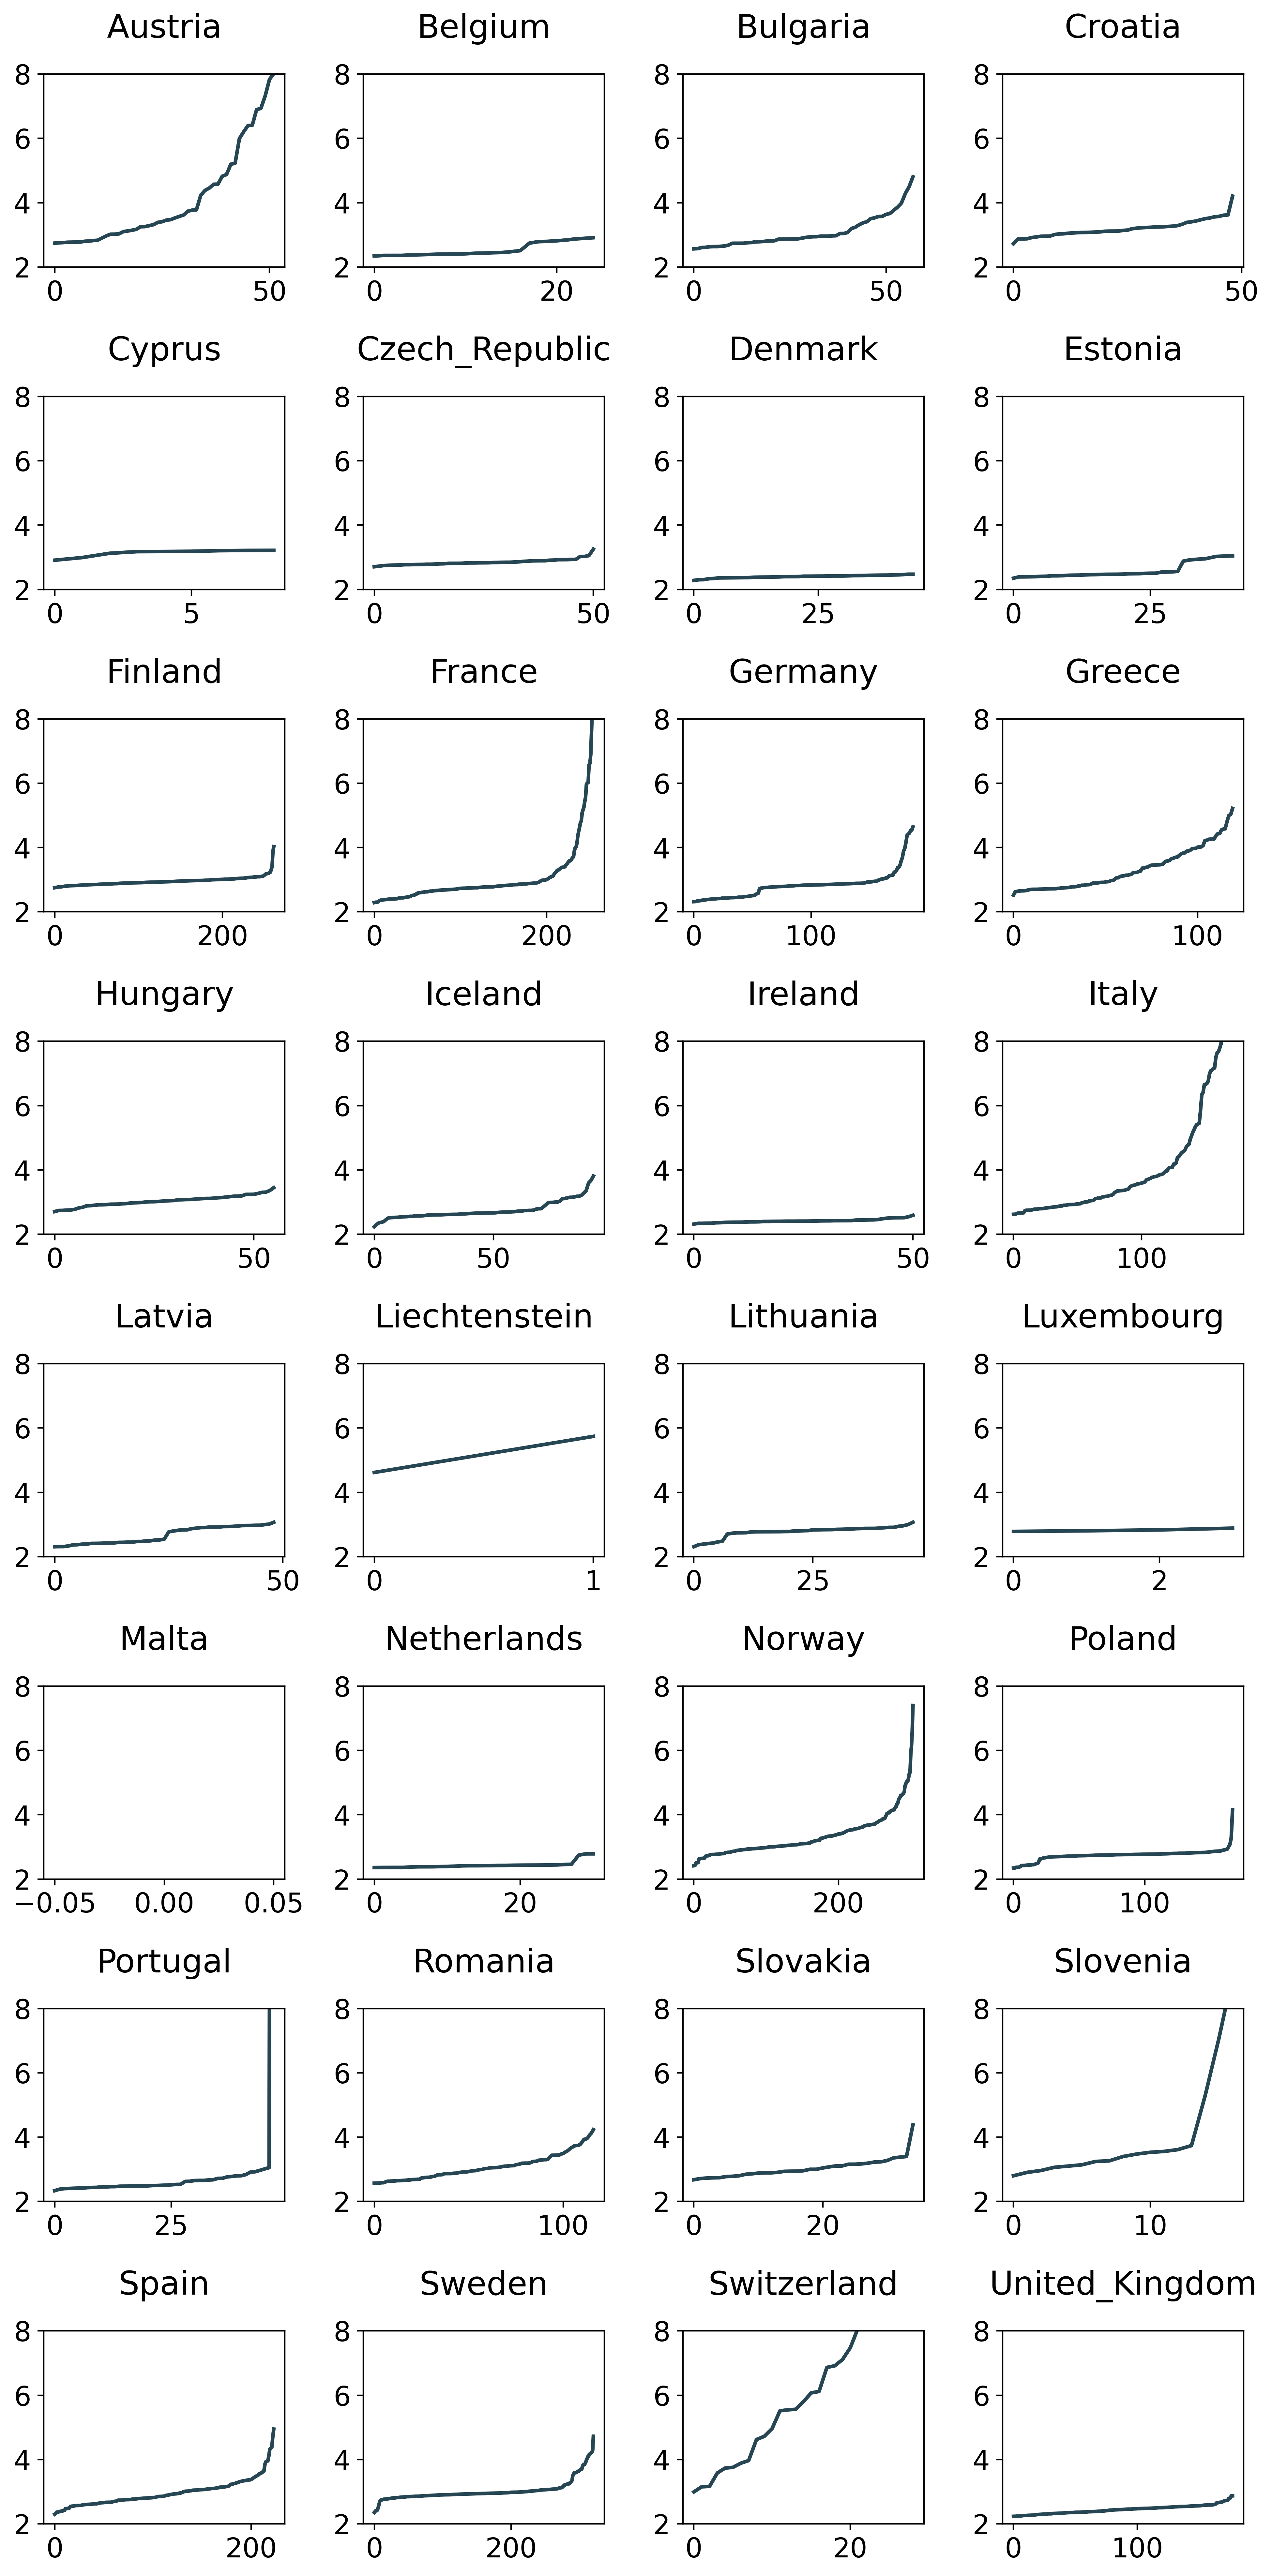

In [10]:
fig = plt.figure(figsize=(10,20))

i=1
for cty in cty_list:
    ax = fig.add_subplot(8,4,i)
    _cty_df = results[results['country'] == cty]
    plt.plot(sorted(_cty_df.LCOF_liter))
    plt.title(cty)
    plt.ylim(2,8)
    plt.tight_layout()
    i+=1
fig.tight_layout()


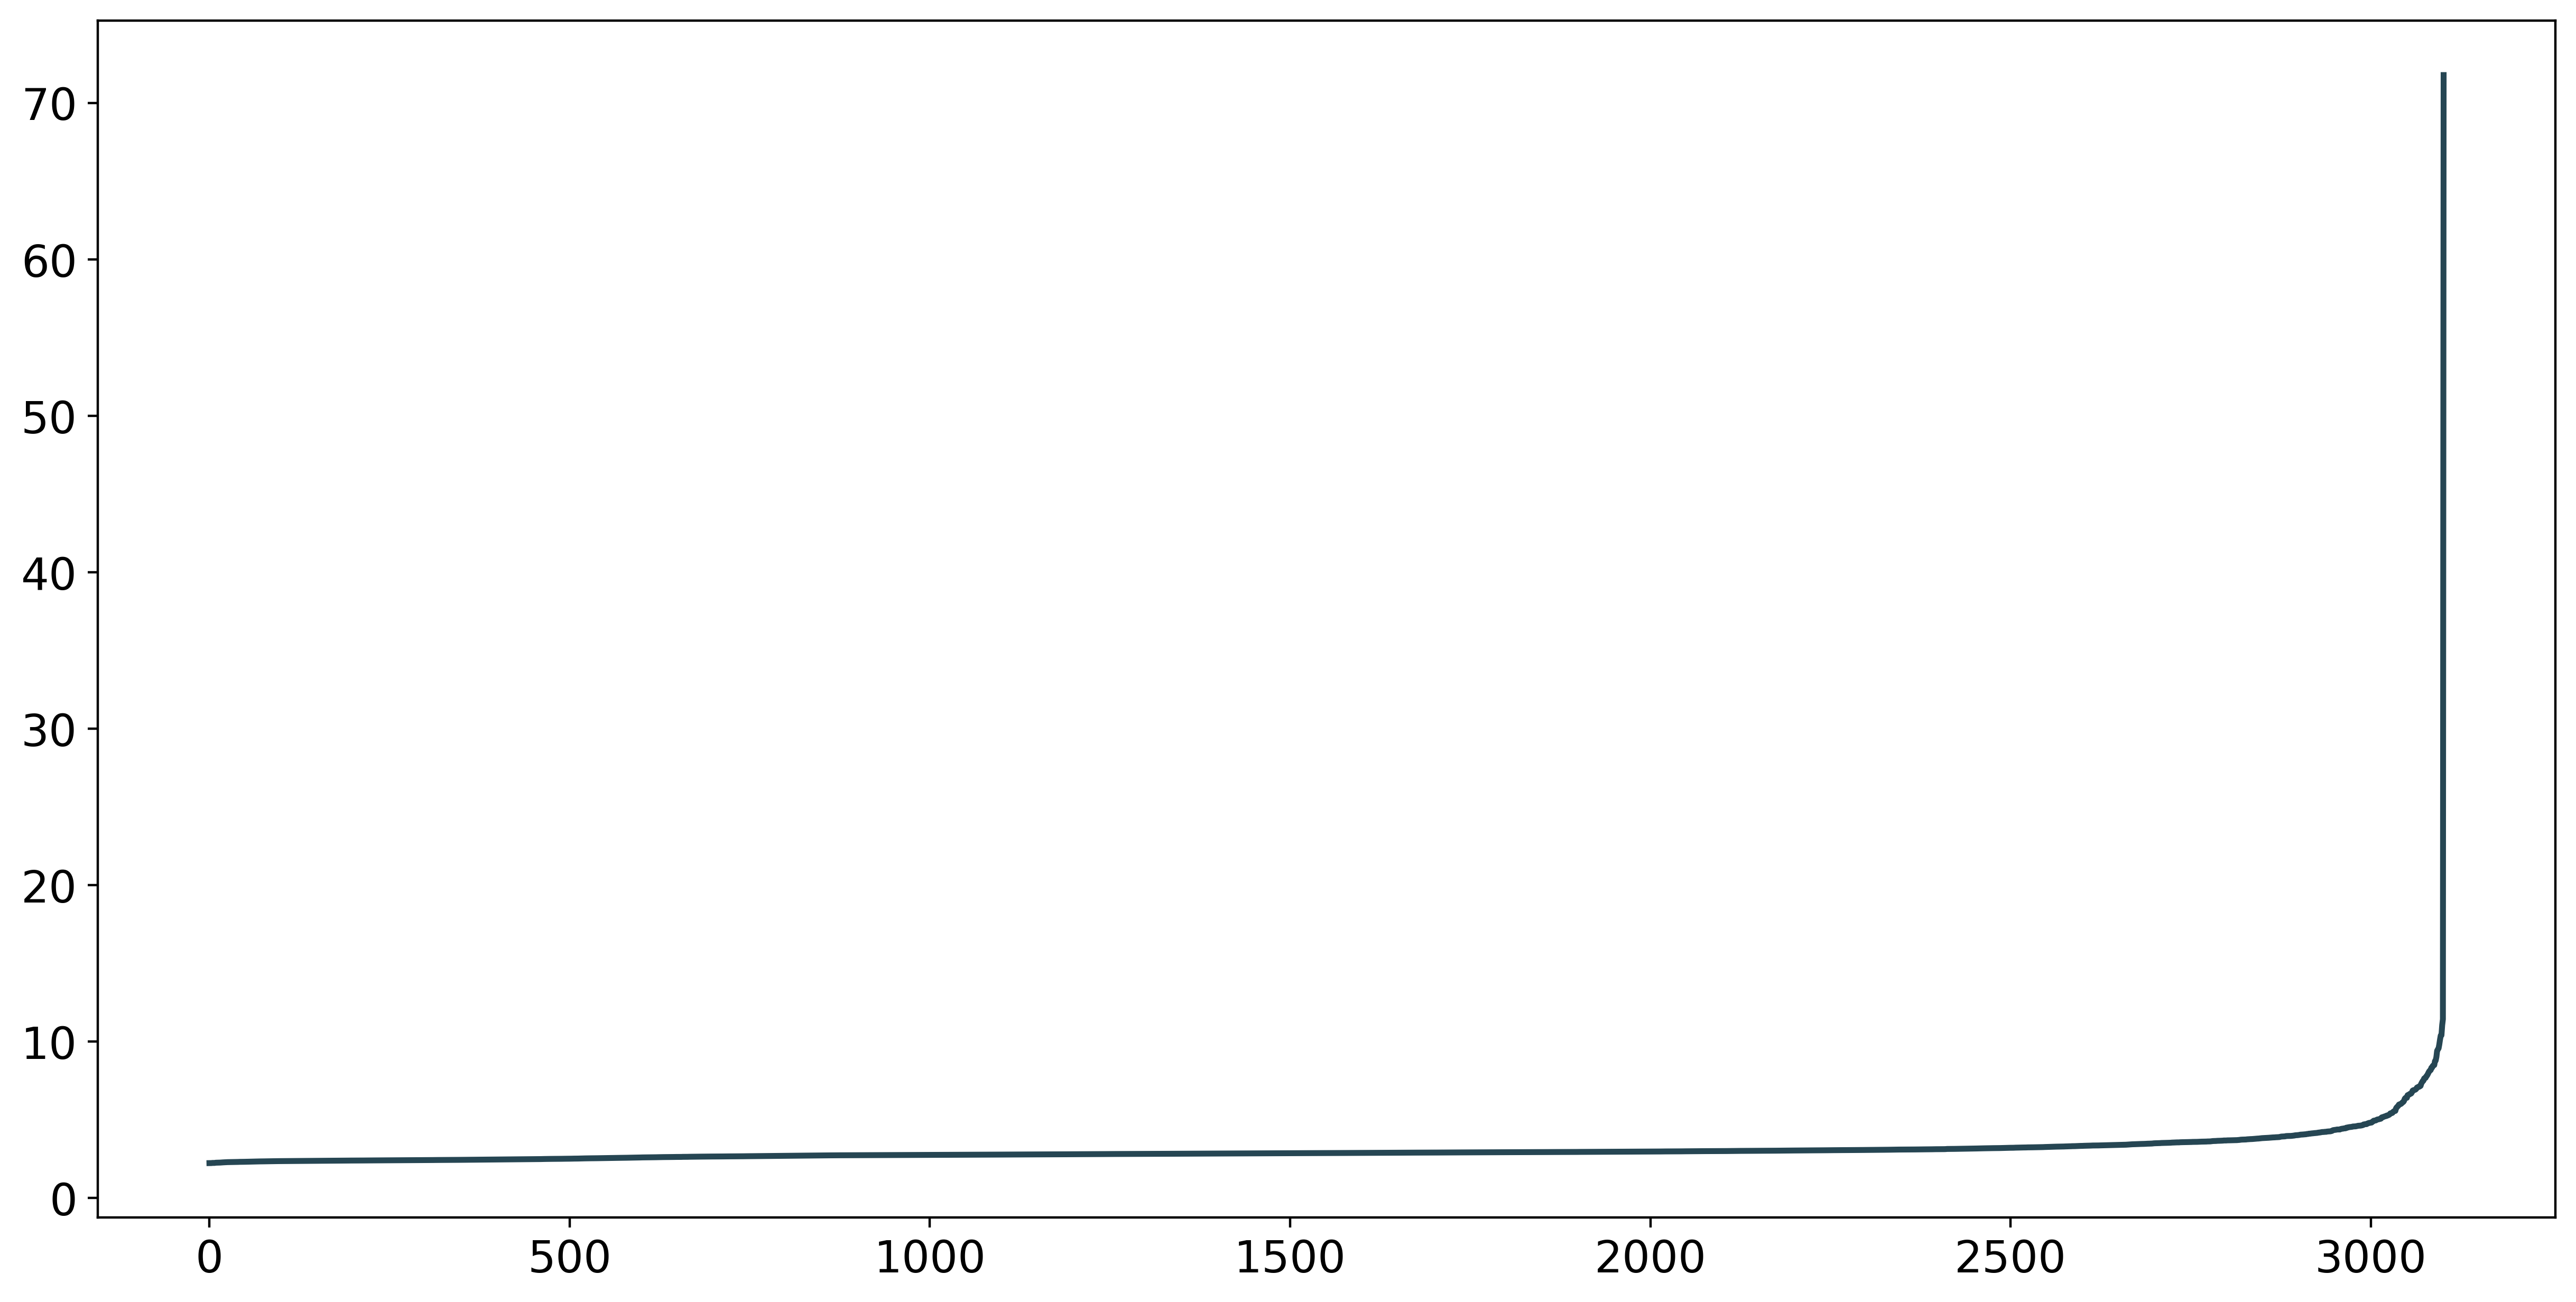

In [11]:
plt.plot(sorted(results.LCOF_liter))

In [12]:
results[results.LCOF_liter < 2.4].groupby('country').count().lat

country
Belgium            8
Denmark           22
Estonia            5
France            22
Germany           16
Iceland            5
Ireland           18
Latvia             8
Lithuania          3
Netherlands       11
Poland             6
Portugal           3
Spain              9
Sweden             2
United_Kingdom    72
Name: lat, dtype: int64

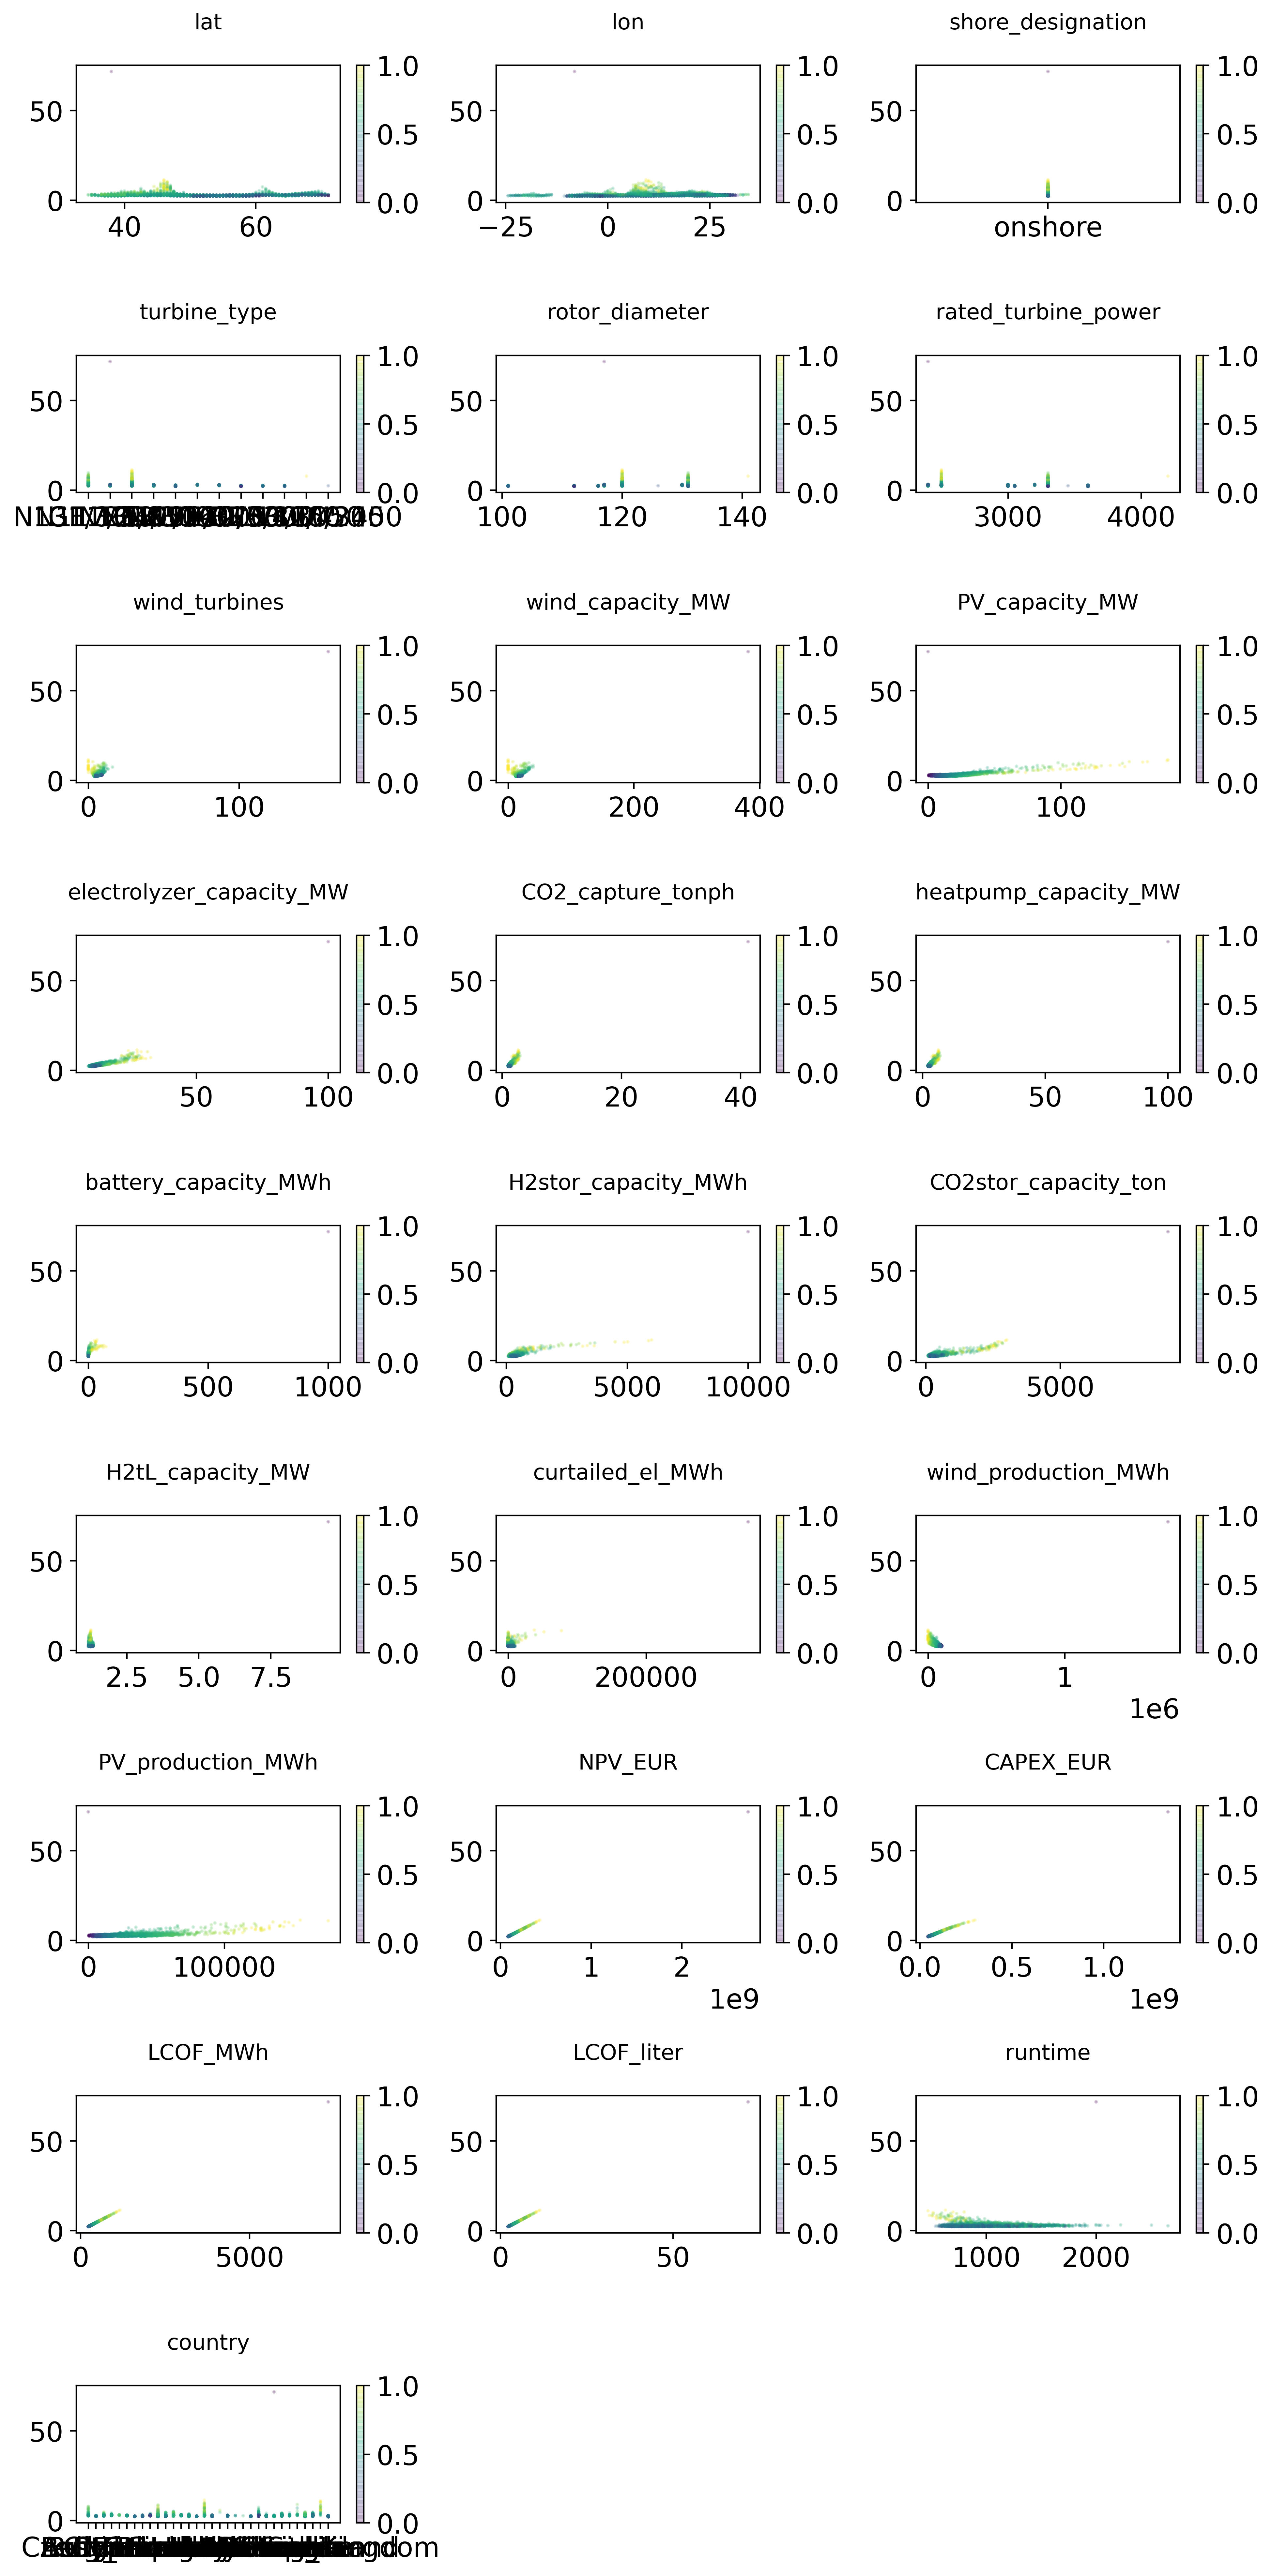

In [13]:
fig = plt.figure(figsize=(10,20))

share_pv = results['PV_capacity_MW']/ (results['PV_capacity_MW'] + results['wind_capacity_MW'])

i=1
for col in results.columns:
    ax = fig.add_subplot(np.round(len(results.columns)/3,0)+1,3,i)
    plt.scatter(results[col], results['LCOF_liter'], alpha=0.2, s=1, c=share_pv, cmap = 'viridis')
    plt.title(col, fontsize=12)
    plt.colorbar()
    plt.tight_layout()
    i+=1
fig.tight_layout()


## Share of PV vs. wind capacity

(0.0, 1.0)

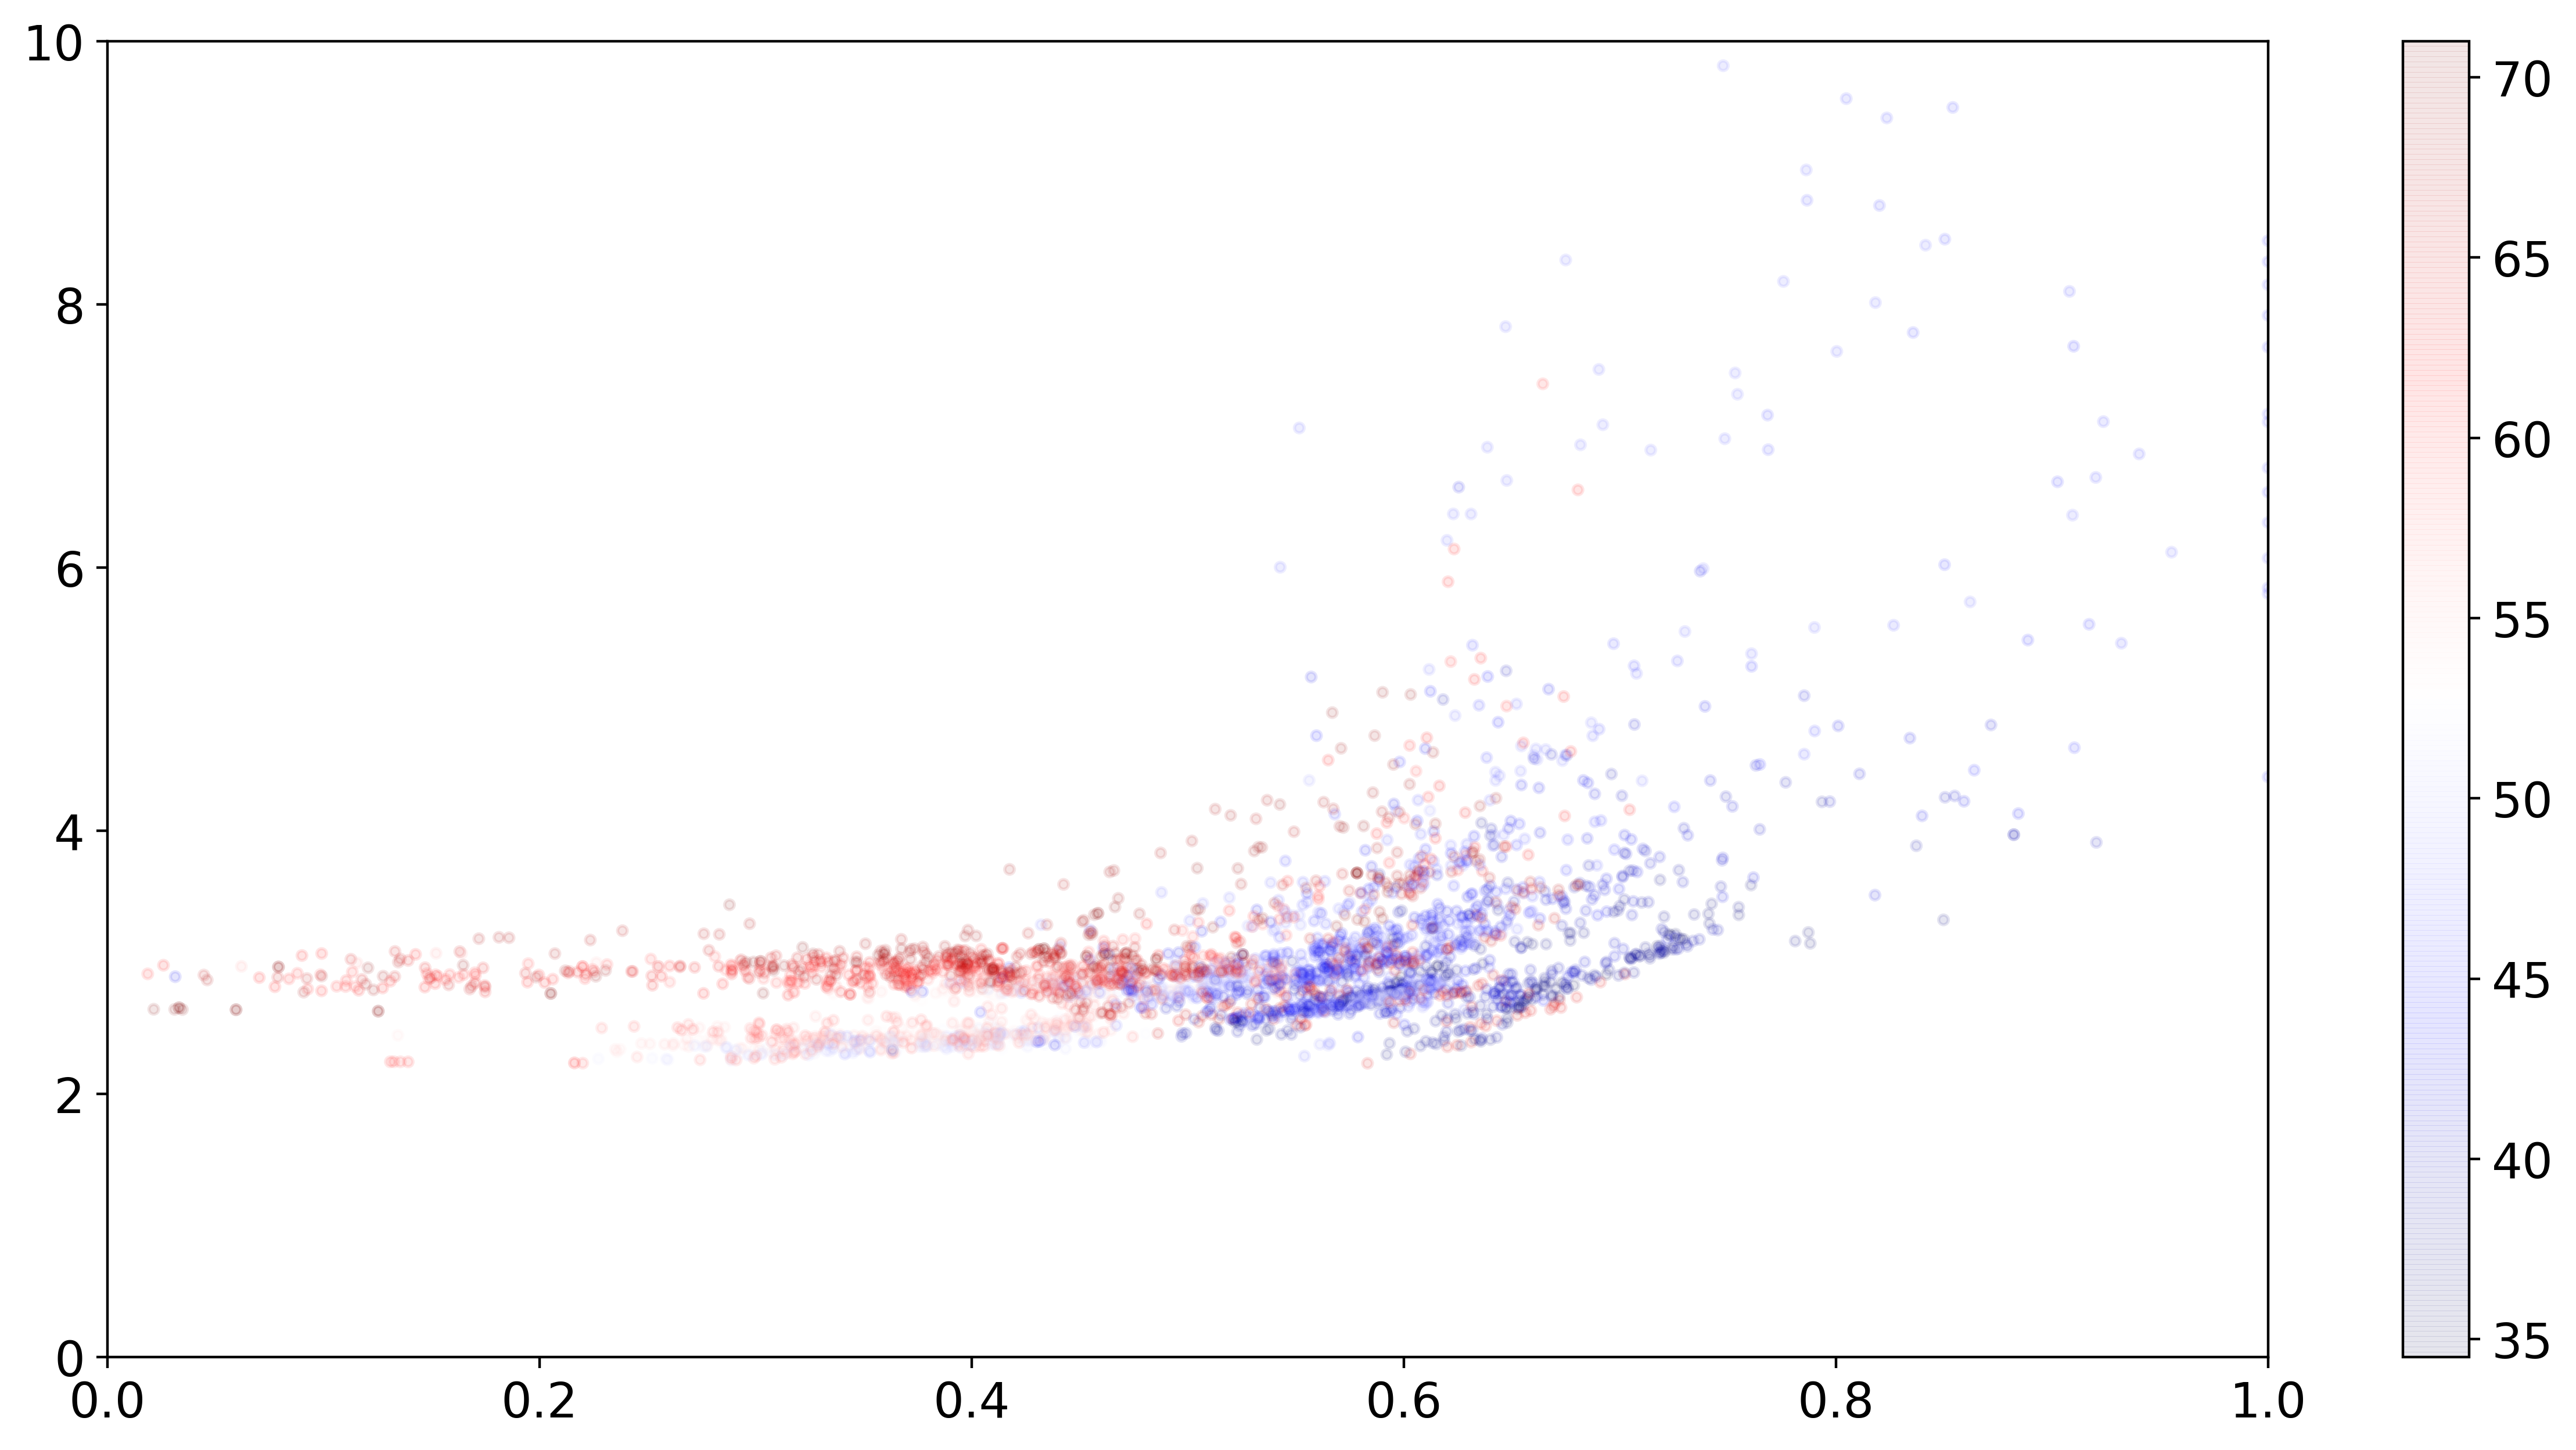

In [14]:
fig = plt.figure()

share_pv = results['PV_capacity_MW']/ (results['PV_capacity_MW'] + results['wind_capacity_MW'])
plt.scatter(share_pv, results['LCOF_liter'], alpha=0.1, s=9, c=results['lat'], cmap = 'seismic')
plt.colorbar()
plt.ylim(0,10)
plt.xlim(0,1)

In [15]:
def plot_cty_set(cty, col):
    df = results[results['country']==cty].copy()
    share_pv = df['PV_capacity_MW']/ (df['PV_capacity_MW'] + df['wind_capacity_MW'])
    plt.scatter(share_pv, df['LCOF_liter'], alpha=0.4, s=20, cmap=col)

(0.0, 1.0)

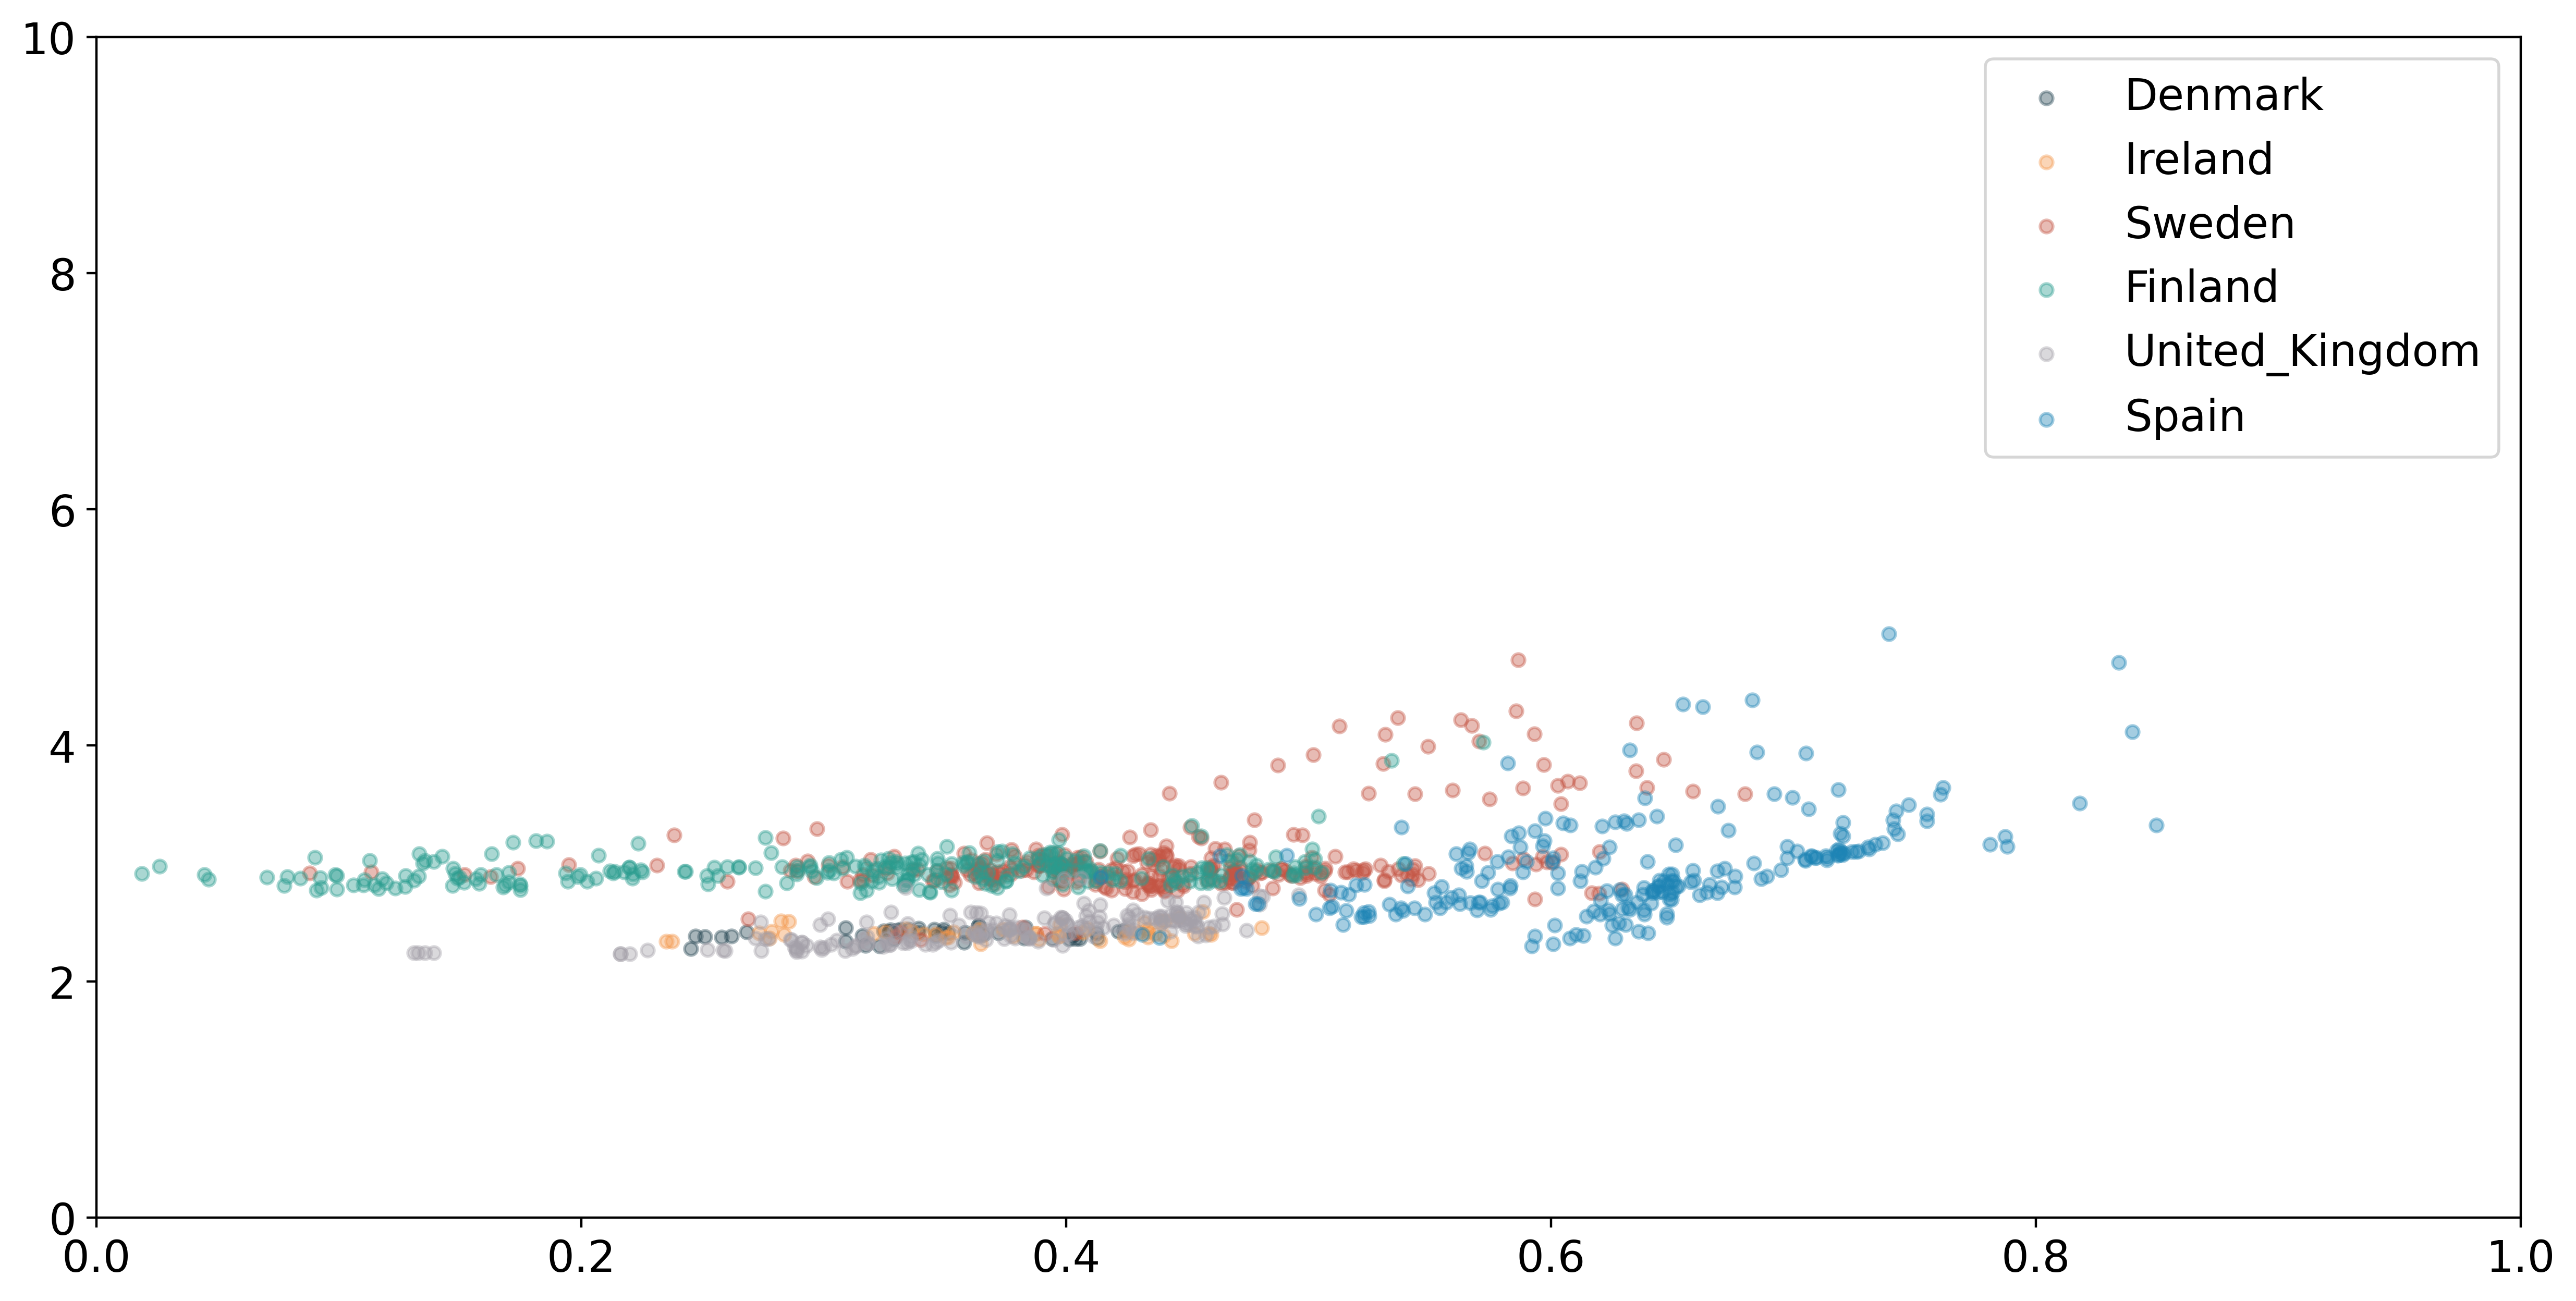

In [16]:
fig = plt.figure()

cty_plot_list = ['Denmark','Ireland','Sweden','Finland','United_Kingdom', 'Spain']

i=0
for cty in cty_plot_list:
    plot_cty_set(cty, cmap[i])
    i+=1

plt.legend(cty_plot_list)
plt.ylim(0,10)
plt.xlim(0,1)

In [17]:
### Wind-focused
# Upper arm = Finland, Sweden
# Lower arm = UK, Ireland, Denmark

### PV-focused
# low-costs even for higher PV shares: Spain (but currently points missing)

(0.0, 10.0)

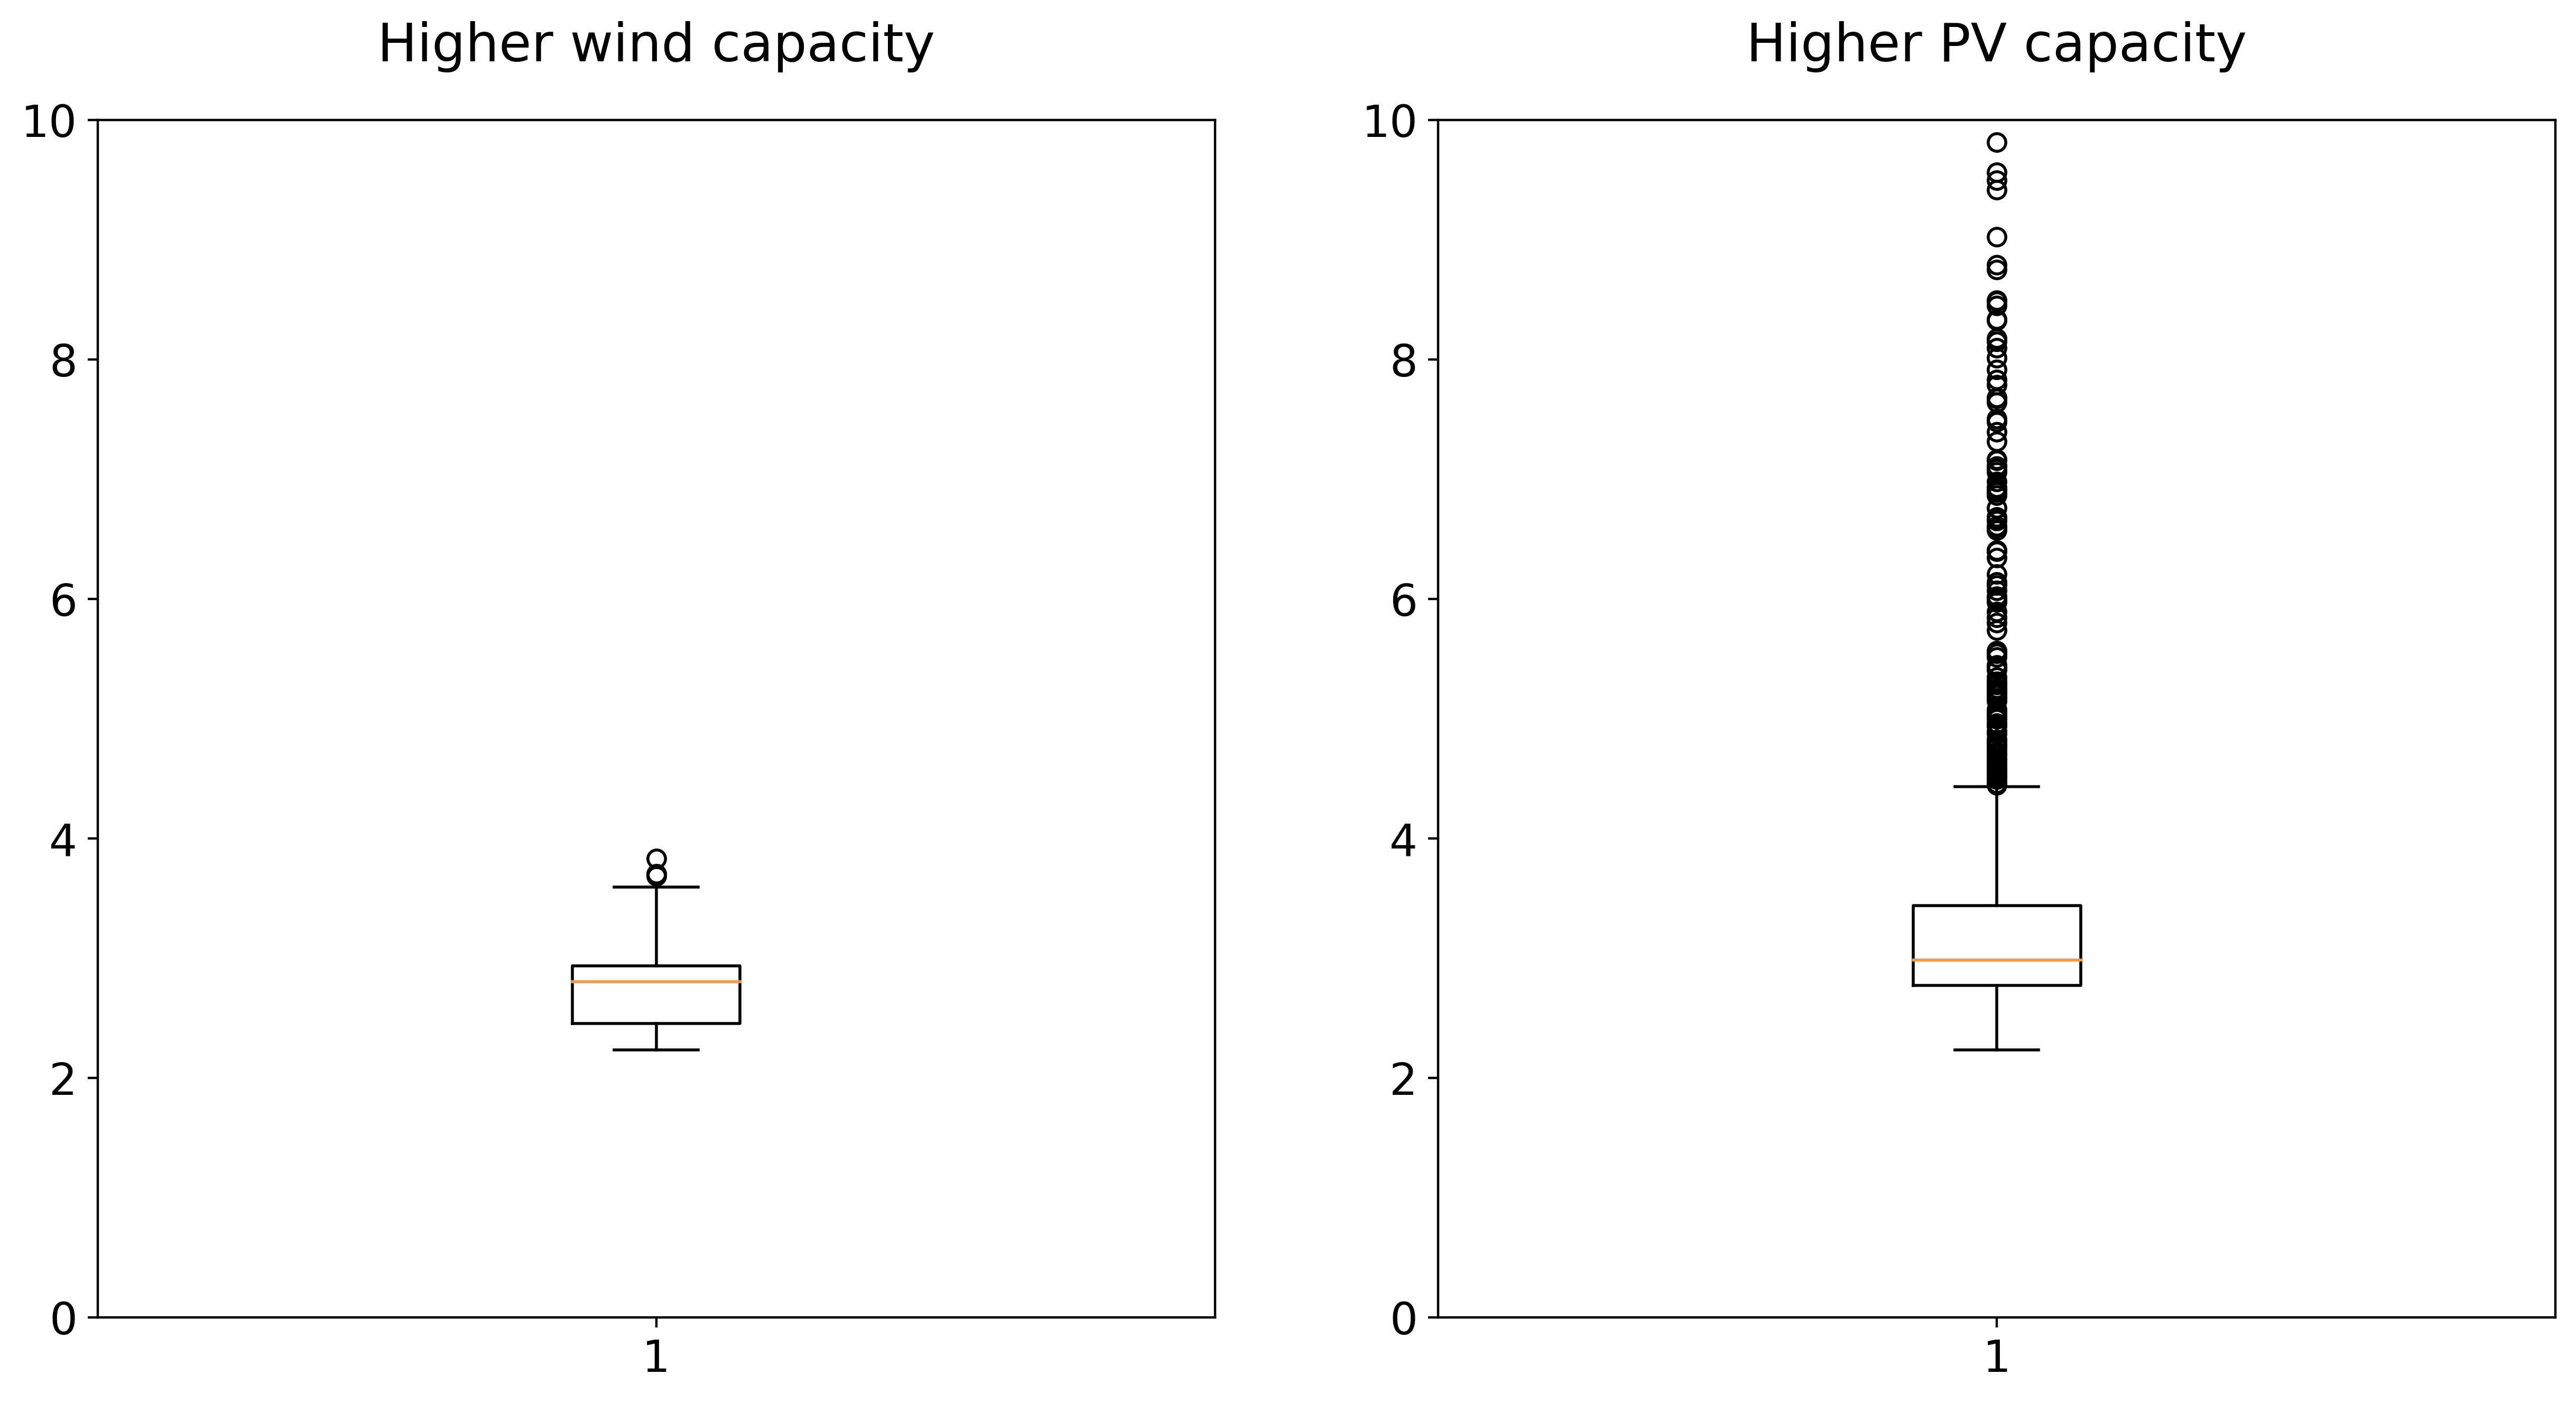

In [18]:
fig = plt.figure()

ax = fig.add_subplot(121)
plt.boxplot(results[results['PV_capacity_MW'] < results['wind_capacity_MW']].LCOF_liter)
plt.title('Higher wind capacity')
plt.ylim(0,10)

ax = fig.add_subplot(122)
plt.boxplot(results[results['PV_capacity_MW'] > results['wind_capacity_MW']].LCOF_liter)
plt.title('Higher PV capacity')
plt.ylim(0,10)

(0.0, 10.0)

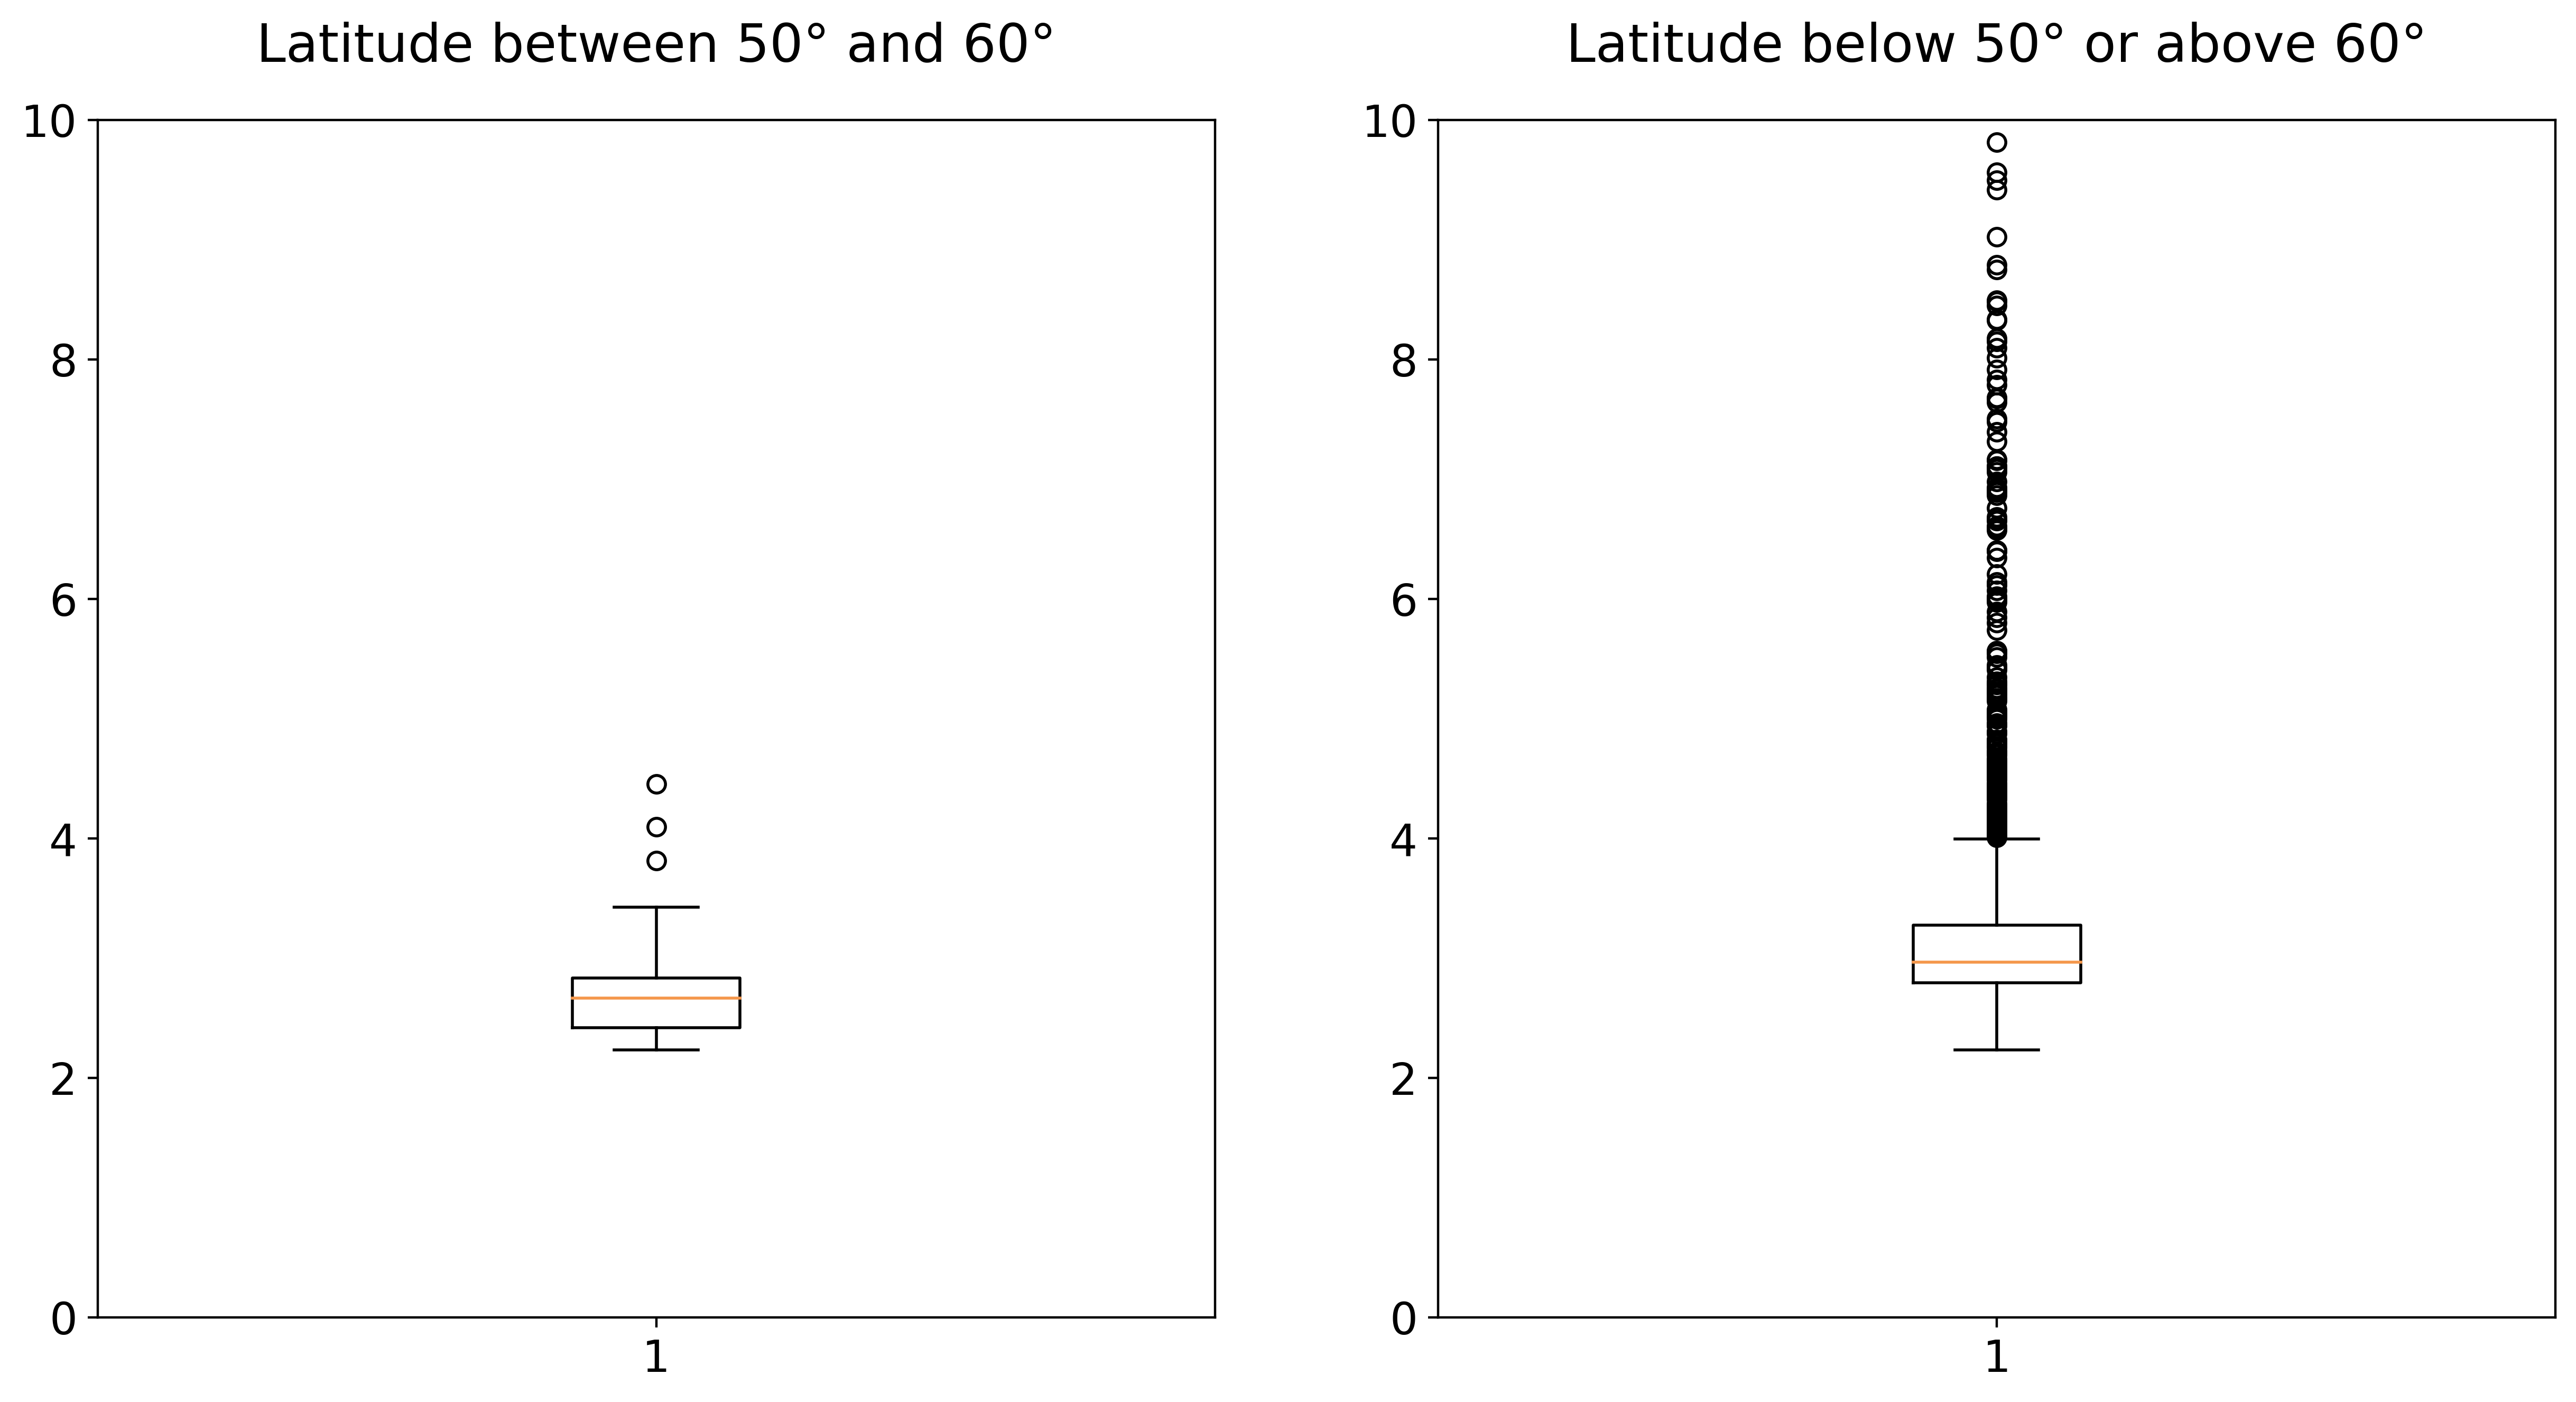

In [19]:
fig = plt.figure()

ax = fig.add_subplot(121)
plt.boxplot(results[(results['lat'] >= 50) & (results['lat'] <= 60)].LCOF_liter)
plt.title('Latitude between 50° and 60°')
plt.ylim(0,10)

ax = fig.add_subplot(122)
plt.boxplot(results[(results['lat'] < 50) | (results['lat'] > 60)].LCOF_liter)
plt.title('Latitude below 50° or above 60°')
plt.ylim(0,10)

## Plot maps

In [20]:
import plant_optimization as pop
from plant_optimization.notebook_tools import *

In [21]:
results_gdf = gpd.GeoDataFrame(results.merge(europe_grid.rename(columns={'name':'country'}),on=['lat','lon','country'],how='left'))

In [22]:
def plot_results(data,countries,metrics,figsize=(25,20),ncols=None,fontsize=None,cmap=None,vmax=None,missing_kwds=None,legend_kwds={}):
    if ncols == None:
        ncols = int(np.ceil(np.sqrt(len(metrics))))
    nrows = int(np.ceil(len(metrics)/ncols))
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    axes = np.reshape(axes,(1,nrows*ncols))[0]

    if fontsize == None:
        fontsize = figsize[0]*2
    df = data.loc[data.country.isin(countries)].copy()
    borders = europe_borders.loc[europe_borders.country.isin(countries)].copy()
    for i,(metric,description) in enumerate(metrics.items()):
        if metric not in ['turbine_type','specific_capacity_class']:
            l_kwds = legend_kwds.copy()
            l_kwds.setdefault('orientation','horizontal')
            l_kwds['ax'] = axes[i]
            l_kwds.pop('bbox_to_anchor',None)
            l_kwds.pop('fontsize',None)
        else:
            l_kwds = legend_kwds.copy()
            l_kwds.pop('orientation',None)
            l_kwds.setdefault('loc','upper center')
            l_kwds.setdefault('ncol',min(3,df[metric].nunique()))
            l_kwds.setdefault('fontsize',fontsize*.75)
            
            if df[metric].nunique()>10:
                cmap = 'tab20'
        df.plot(column=metric,legend=True,cmap=cmap,vmax=vmax,missing_kwds=missing_kwds,legend_kwds=l_kwds,ax=axes[i])
        borders.boundary.plot(color='k',ax=axes[i])
        cb_ax = axes[i].figure.axes[-1]
        cb_ax.tick_params(labelsize=fontsize)
        axes[i].axis('off')
        axes[i].set_title(description,fontsize=fontsize)
#     plt.tight_layout()

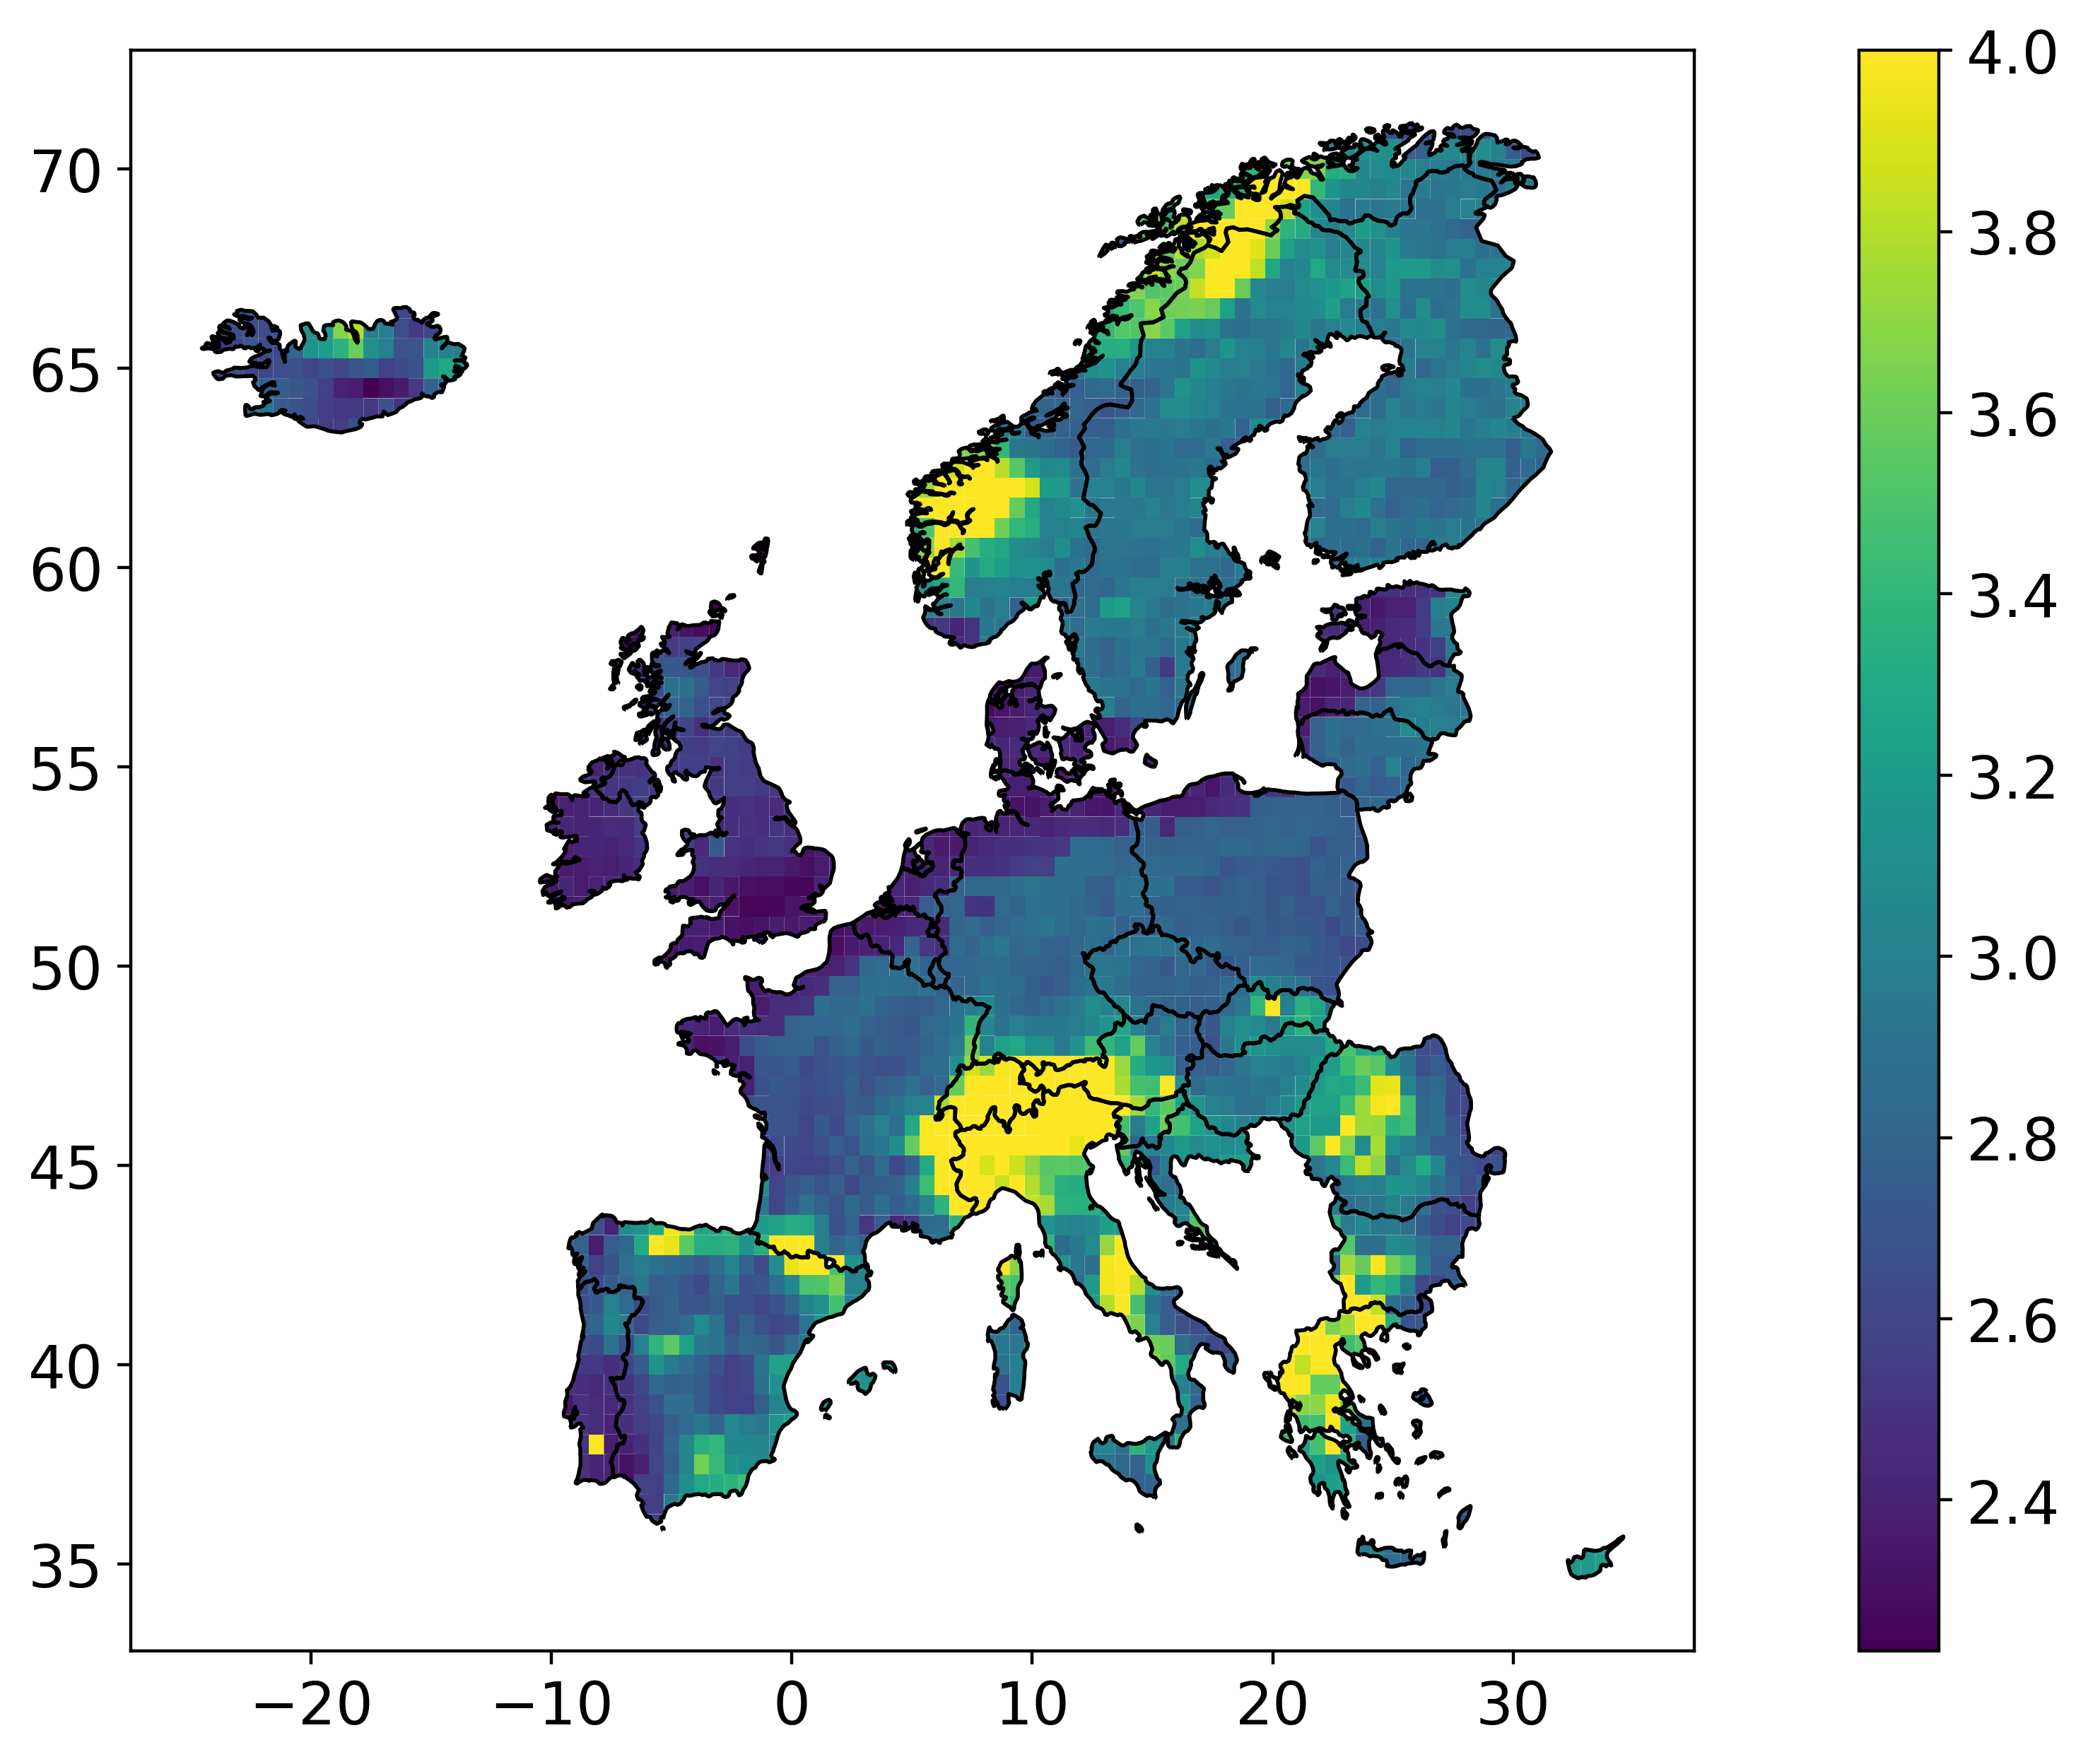

In [23]:
countries = cty_list
metric = 'LCOF_liter'
fontsize = 30

fig = plt.figure()
ax = fig.add_subplot(111)
    
data = results_gdf.copy()
df = data.loc[data.country.isin(countries)].copy()
borders = europe_borders.loc[europe_borders.country.isin(countries)].copy()
df.plot(column=metric, legend=True, vmax=4, ax=ax)
borders.boundary.plot(color='k',ax=ax, lw=1)



In [24]:
data = results_gdf.copy()
countries = cty_list
metrics = {'LCOF_liter':'Levelized cost of fuel [EUR/l]',
           'wind_capacity_MW':'Installed wind power capacity [MW]',
           'PV_capacity_MW':'Installed PV power capacity [MW]',
           'curtailed_el_MWh':'Curtailed electricity production [MWh]'}
fontsize = 40
plot_results(data=data,countries=countries,metrics=metrics,fontsize=fontsize)

In [25]:
results_gdf.sort_values('curtailed_el_MWh',ascending=False).head(3)

lat     lon shore_designation turbine_type  rotor_diameter  \
2149  38.0  -8.125           onshore    N117/2400           117.0   
2919  46.0  10.000           onshore   GE120/2500           120.0   
2915  46.0   9.375           onshore   GE120/2500           120.0   

      rated_turbine_power  wind_turbines  wind_capacity_MW  PV_capacity_MW  \
2149               2400.0          159.0             381.6        0.000000   
2919               2500.0           -0.0              -0.0      179.891019   
2915               2500.0           -0.0              -0.0      165.125642   

      electrolyzer_capacity_MW  ...  PV_production_MWh       NPV_EUR  \
2149                100.000000  ...           0.000000  2.731293e+09   
2919                 24.207199  ...      176162.070737  4.204389e+08   
2915                 29.058120  ...      144213.225911  3.960146e+08   

         CAPEX_EUR     LCOF_MWh  LCOF_liter      runtime      country  \
2149  1.350265e+09  7323.670420   71.771970  2000.244433     Portugal   
2919  2.889247e+08  1127.362154   11.048149   468.194117  Switzerland   
2915  2.670349e+08  1061.871077   10.406337   696.679099  Switzerland   

         PV_lat     PV_lon                                           geometry  
2149  38.000000  -8.125000  POLYGON ((-8.43750 38.25000, -7.81250 38.25000...  
2919  46.239057  10.098074  POLYGON ((10.04078 46.25000, 10.15876 46.25000...  
2915  46.201241   9.129877  MULTIPOLYGON (((9.06250 46.25000, 9.25093 46.2...  

[3 rows x 28 columns]

# Analyse data for single countries

In [26]:
countries = ['Switzerland','Austria']
results = pd.DataFrame()
for country in countries:
    df = pd.DataFrame()
    for file_glob in glob(f'{results_path}/{country}*.csv'): 
        df = df.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df['country'] = country
    results = results.append(df)

In [27]:
results_gdf = gpd.GeoDataFrame(results.merge(europe_grid.rename(columns={'name':'country'}),on=['lat','lon','country'],how='left'))

In [28]:
def plot_results(data,countries,metrics,figsize=(25,20),ncols=None,fontsize=None,cmap=None,vmax=None,missing_kwds=None,legend_kwds={}):
    if ncols == None:
        ncols = int(np.ceil(np.sqrt(len(metrics))))
    nrows = int(np.ceil(len(metrics)/ncols))
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    axes = np.reshape(axes,(1,nrows*ncols))[0]

    if fontsize == None:
        fontsize = figsize[0]*2
    df = data.loc[data.country.isin(countries)].copy()
    borders = europe_borders.loc[europe_borders.country.isin(countries)].copy()
    for i,(metric,description) in enumerate(metrics.items()):
        if metric not in ['turbine_type','specific_capacity_class']:
            l_kwds = legend_kwds.copy()
            l_kwds.setdefault('orientation','horizontal')
            l_kwds['ax'] = axes[i]
            l_kwds.pop('bbox_to_anchor',None)
            l_kwds.pop('fontsize',None)
        else:
            l_kwds = legend_kwds.copy()
            l_kwds.pop('orientation',None)
            l_kwds.setdefault('loc','upper center')
            l_kwds.setdefault('ncol',min(3,df[metric].nunique()))
            l_kwds.setdefault('fontsize',fontsize*.75)
            
            if df[metric].nunique()>10:
                cmap = 'tab20'
        df.plot(column=metric,legend=True,cmap=cmap,vmax=vmax,missing_kwds=missing_kwds,legend_kwds=l_kwds,ax=axes[i])
        borders.boundary.plot(color='k',ax=axes[i])
        cb_ax = axes[i].figure.axes[-1]
        cb_ax.tick_params(labelsize=fontsize)
        axes[i].axis('off')
        axes[i].set_title(description,fontsize=fontsize)
#     plt.tight_layout()

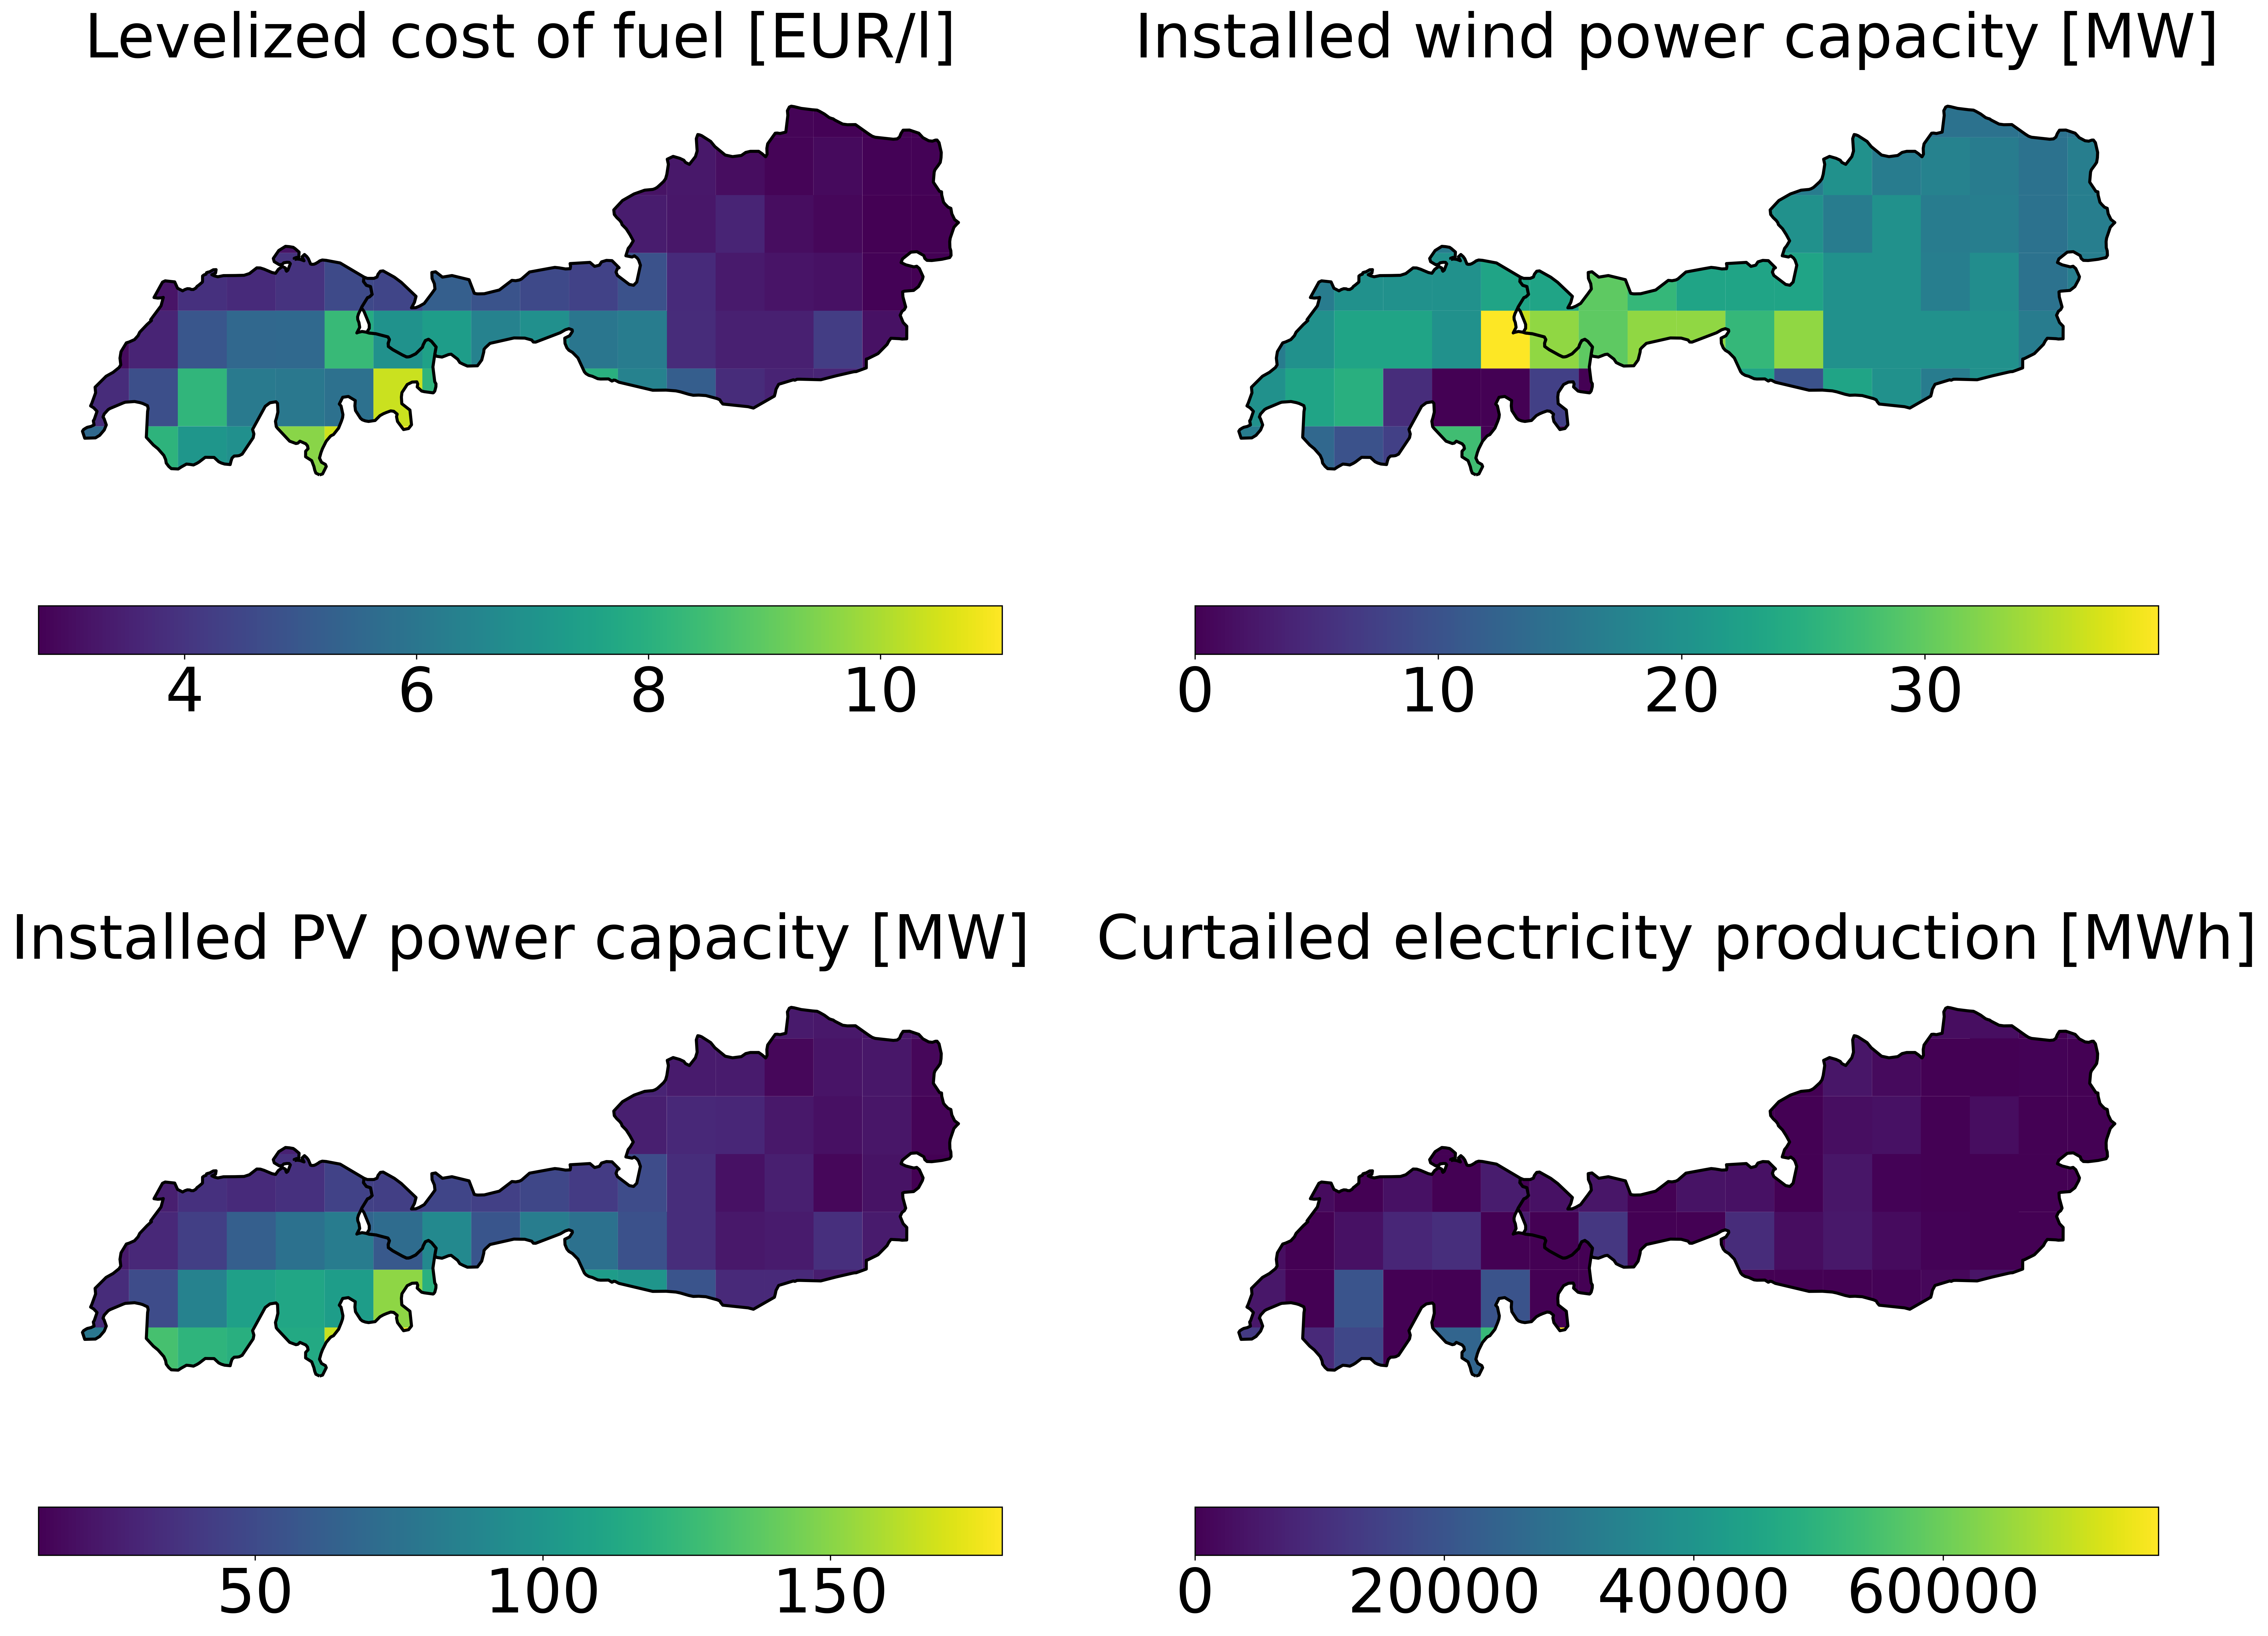

In [29]:
data = results_gdf.copy()
countries = ['Switzerland','Austria']
metrics = {'LCOF_liter':'Levelized cost of fuel [EUR/l]',
           'wind_capacity_MW':'Installed wind power capacity [MW]',
           'PV_capacity_MW':'Installed PV power capacity [MW]',
           'curtailed_el_MWh':'Curtailed electricity production [MWh]'}
fontsize = 40
plot_results(data=data,countries=countries,metrics=metrics,fontsize=fontsize)

In [30]:
country = 'Austria'
point = (47.5,10.625)
site = pop.Site(point,country)
plant = pop.Plant(site)
plant.operation = pd.read_parquet(f'../paper_preparation/results/operation/{country}_{point[0]}_{point[1]}.parquet.gzip')
plant.operation.head()

wind_production_kWh  PV_production_kWh  battery_chr_kWh  \
time                                                                           
2016-01-01 00:30:00             0.000000                0.0         0.000000   
2016-01-01 01:30:00             0.000000                0.0         0.000000   
2016-01-01 02:30:00           413.425308                0.0       200.785118   
2016-01-01 03:30:00          1868.782413                0.0         0.000000   
2016-01-01 04:30:00          3985.034821                0.0         0.000000   

                     battery_dis_kWh  battery_state_kWh  H2stor_chr_kWh  \
time                                                                      
2016-01-01 00:30:00       212.640189         459.762572    9.996428e+06   
2016-01-01 01:30:00       212.640189         229.881286    0.000000e+00   
2016-01-01 02:30:00         0.000000           0.000000    0.000000e+00   
2016-01-01 03:30:00         0.000000         185.726234    0.000000e+00   
2016-01-01 04:30:00         0.000000         185.726234    9.998691e+06   

                     H2stor_dis_kWh  H2stor_state_kWh  CO2stor_chr_kg  \
time                                                                    
2016-01-01 00:30:00    1.000000e+07     112214.263482    9.999320e+06   
2016-01-01 01:30:00    3.572366e+03     108641.897771    9.999320e+06   
2016-01-01 02:30:00    3.572366e+03     105069.532061    9.999320e+06   
2016-01-01 03:30:00    2.578680e+03     101497.166351    0.000000e+00   
2016-01-01 04:30:00    1.000000e+07      98918.485975    0.000000e+00   

                     CO2stor_dis_kg  ...    H2_el_kWh  CO2_el_kWh  \
time                                 ...                            
2016-01-01 00:30:00    1.000000e+07  ...     0.000000  212.640189   
2016-01-01 01:30:00    1.000000e+07  ...     0.000000  212.640189   
2016-01-01 02:30:00    1.000000e+07  ...     0.000000  212.640189   
2016-01-01 03:30:00    6.799714e+02  ...  1656.142224  212.640189   
2016-01-01 04:30:00    6.799714e+02  ...  3772.394631  212.640189   

                     H2tL_el_kWh  heat_el_kWh  battery_flow_kWh  \
time                                                              
2016-01-01 00:30:00          0.0          0.0       -212.640189   
2016-01-01 01:30:00          0.0          0.0       -212.640189   
2016-01-01 02:30:00          0.0          0.0        200.785118   
2016-01-01 03:30:00          0.0          0.0          0.000000   
2016-01-01 04:30:00          0.0          0.0          0.000000   

                     H2_production_kWh  CO2_consumption_kg  CO2_production_kg  \
time                                                                            
2016-01-01 00:30:00           0.000000       133580.089797      132900.118411   
2016-01-01 01:30:00           0.000000       133580.089797      132900.118411   
2016-01-01 02:30:00           0.000000       133580.089797      132900.118411   
2016-01-01 03:30:00         993.685334       133580.089797      132900.118411   
2016-01-01 04:30:00        2263.436779       133580.089797      132900.118411   

                     CO2stor_flow_kg  fuel_production_kWh  
time                                                       
2016-01-01 00:30:00      -679.971386          1019.397409  
2016-01-01 01:30:00      -679.971386          1019.397409  
2016-01-01 02:30:00      -679.971386          1019.397409  
2016-01-01 03:30:00      -679.971386          1019.397409  
2016-01-01 04:30:00      -679.971386          1019.397409  

[5 rows x 22 columns]

AttributeError: 'Plant' object has no attribute 'wind_production_MWh'

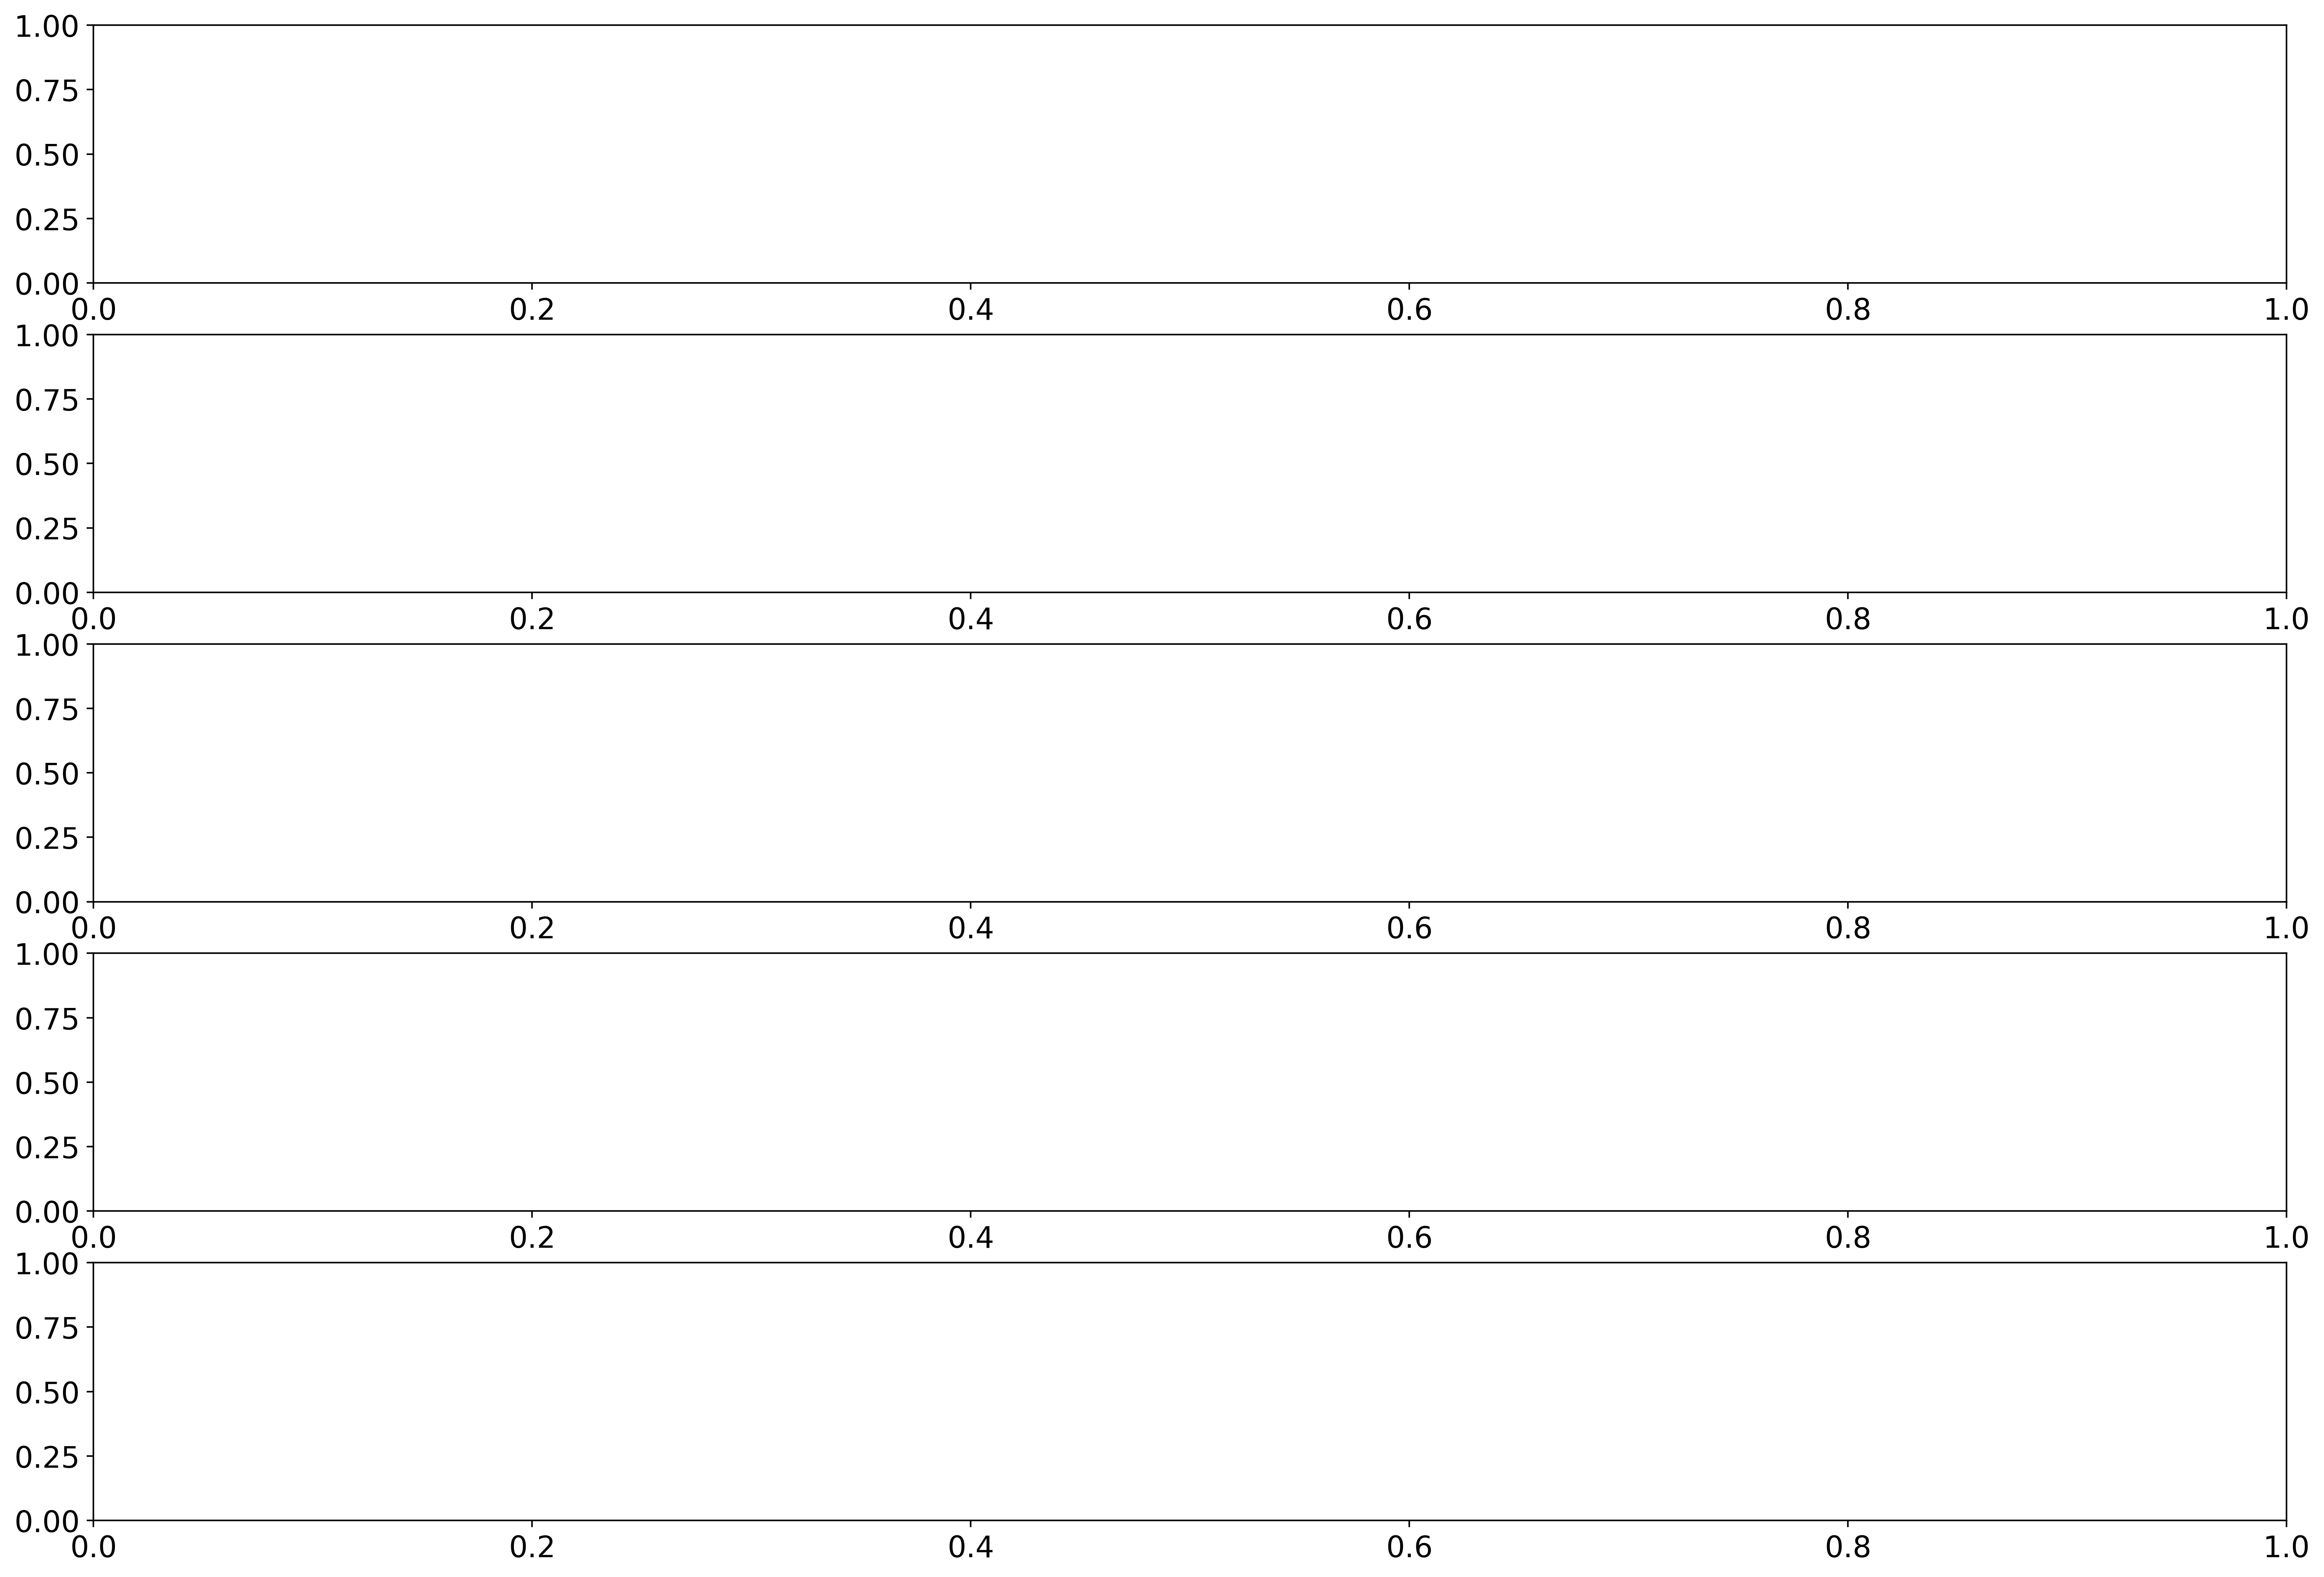

In [31]:
plot_plant_operation(plant)